# Advanced Data Analysis 23/24: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: Kuba Białczyk, 61678
## Student 2: Paul Schuhmann, 59482


\**In the solutions for exercises 1 to 4 you should include necessarily one solution using Pandas/scikit learn and one using Spark.**

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [ ]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

In [ ]:
# for cuDF
!nvidia-smi
!nvcc -V

!pip uninstall --yes protobuf tensorflow tensorboard; pip install cupy-cuda11x

!pip install cudf-cu11 dask-cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url https://pypi.nvidia.com

Tue Dec  5 16:19:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install software

This cell installs the software needed to run the project.

In [ ]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.9+9-1~22.04 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.9+9-1~22.04 [71.1 MB]
Fetched 119 MB in 11s (11.3 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 120882

## Setup

The following cell will import the used packages.

In [ ]:
from zipfile import ZipFile
import time

# loading cuDF version of pandas that automatically runs possible tasks on GPU
# with the use of cuDF or CPU with normal pandas if tasks are not supported by cuDF
# cuDF pandas documentation -> https://docs.rapids.ai/api/cudf/stable/cudf_pandas/
%load_ext cudf.pandas
import pandas as pd
#import cuml.cluster
#import sklearn.cluster
import numpy as np
import ast
import matplotlib.pyplot as plt
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

# instantiate
tqdm.pandas()


## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls drive/MyDrive/Colab\ Notebooks/NOVA/sbe2324ada/labels

Mounted at /content/drive
Exchanges_full_detailed.csv  labels-260001-270000.csv.gz  labels-343001-349000.csv.gz
Gambling_full_detailed.csv   labels-270001-280000.csv.gz  labels-349001-354000.csv.gz
Historic_full_detailed.csv   labels-280001-290000.csv.gz  labels-354001-360000.csv.gz
labels-0-68732.csv.gz	     labels-290001-300000.csv.gz  labels-360001-364000.csv.gz
labels-190001-209999.csv.gz  labels-300001-310000.csv.gz  labels-364001-367000.csv.gz
labels-210000-224000.csv.gz  labels-310001-320000.csv.gz  labels-367001-369999.csv.gz
labels-224001-234000.csv.gz  labels-320001-329999.csv.gz  labels.csv.gz
labels-234001-247000.csv.gz  labels-330000-337000.csv.gz  Mining_full_detailed.csv
labels-247001-260000.csv.gz  labels-337001-343000.csv.gz  Services_full_detailed.csv


In [4]:
#DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "drive/MyDrive/Colab Notebooks/NOVA/sbe2324ada"

# Small dataset
TXDATA_FILE = "0-68732.csv.gz"
# Larger dataset
# TXDATA_FILE_LARGE = "234001-247000.csv.gz"
#TXDATA_FILE_LARGE = "367001-369999.csv.gz"
TXDATA_FILE_LARGE = "364001-367000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"



### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [5]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)

df = pd.read_csv(path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)

TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE_LARGE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



## Exercise 0 [1 point]

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
for filename in [TXDATA_FILE, TXDATA_FILE_LARGE]:
  start_time = time.time()

  date_cols = ["Time"]
  path = os.path.join(DATASET_DIR, filename)
  df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

  df['Input'] = df['Input'].apply(ast.literal_eval)
  df['Output'] = df['Output'].apply(ast.literal_eval)

  inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

  outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
  outputDF[["Output","Value"]] = outputDF["Output"].to_list()

  addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
  addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
  addr=addr_in.join(addr_out,how="outer").fillna(0)
  addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
  #print(addr.nlargest(10,"cnt"))


  end_time = time.time()
  print( f"Runtime [for file: {filename}] = " + str(end_time - start_time)+"\n\n")


Runtime [for file: 0-68732.csv.gz] = 3.883002758026123


Runtime [for file: 364001-367000.csv.gz] = 231.66933250427246




In [ ]:
transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)

TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


In [ ]:
# saving dataframes for the large file not to load and transform again
inputDF.to_csv('inputDF.csv')
outputDF.to_csv('outputDF.csv')
transactionDF.to_csv('transactionDF.csv')

### Results (Pandas)

The time to process the small dataset was : **3.88** seconds.

The time to process the large dataset was : **231.67** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

for filename in [TXDATA_FILE, TXDATA_FILE_LARGE]:
    start_time = time.time()

    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", FloatType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                            sep=",", schema=mySchema, header="true")
    dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
    dataset = dataset.withColumn("Output",split("Output","\]\, \["))
    dataset.createOrReplaceTempView("data")

    inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                      FROM data""")
    inputSDF.createOrReplaceTempView("input")

    outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                          FROM data""")
    outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
    outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
    outputSDF = outputSDF.withColumn("output",expr("output[0]"))
    outputSDF.createOrReplaceTempView("output")

    spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
                  (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
                  (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                    ORDER BY cnt DESC
                    LIMIT 10""").show(truncate=False)
    end_time = time.time()

    print( f"Runtime [for file: {filename}] = " + str(end_time - start_time))


+------------------------------------+----+------+-------+
|addr                                |cnt |cnt_in|cnt_out|
+------------------------------------+----+------+-------+
|'18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT'|3668|10    |3658   |
|'1XPTgDRhN8RFnzniWCddobD9iKZatrvH4' |3137|12    |3125   |
|'1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp'|600 |6     |594    |
|'15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC'|312 |6     |306    |
|'1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma'|208 |1     |207    |
|'15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC'|202 |93    |109    |
|'1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p'|147 |1     |146    |
|'1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV'|147 |10    |137    |
|'16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4'|126 |43    |83     |
|'18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk'|122 |16    |106    |
+------------------------------------+----+------+-------+

Runtime [for file: 0-68732.csv.gz] = 11.711323499679565
+------------------------------------+-----+------+-------+
|addr                                |cnt  |cnt_in|cnt_ou

### Results (Spark)

The time to process the small dataset was : **11.71** seconds.

The time to process the large dataset was : **112.92** seconds.



### Discussion:

<h3>Pandas in a Single-Machine Environment:</h3>

1. Performance with Small vs. Large Datasets:

Pandas, designed for in-memory computing on a single machine, shows excellent performance with small datasets (few thousand rows). This efficiency is due to its ability to quickly process data that comfortably fits into the available RAM.
However, with larger datasets (millions of rows), Pandas' performance degrades significantly. The jump in processing time from a few seconds for small datasets to several minutes for larger ones is attributed to the limitation of available memory. As the dataset size approaches or exceeds the RAM capacity, Pandas has to rely on disk storage (swapping), which is substantially slower than in-memory operations.

2. Resource Limitations on Google Colab:

Google Colab provides a decent amount of RAM but it's finite and can be quickly exhausted by large datasets. This limitation is a critical factor in Pandas' reduced efficiency when handling large data volumes.
<h3>Apache Spark in the Same Environment:</h3>

1. Distributed Framework Adaptability:

Despite being a distributed computing system intended for cluster environments, Spark demonstrates impressive adaptability and performance on a single machine like Google Colab. It effectively utilizes the available CPU cores to distribute tasks, enabling efficient data processing.
Spark's runtime is relatively consistent across small and large datasets, indicating its robustness in resource management and task scheduling. Its design allows for effective in-memory computation and processing of complex data manipulations (such as explode, group by, and join operations).

2. Handling Large Datasets on Limited Resources:

Spark's architecture enables it to manage large datasets more efficiently than Pandas in a constrained environment like Google Colab. ***It can handle the computational load of larger datasets in significantly shorter time than Pandas. However, it doesn't improve in terms of small dataset, and can even perform worse then pandas, due to overhead of distribution, being higher then benefit from distributed computing for small datasets. In such a case, it's recommended to use Pandas.***

<h3>Key Comparisons and Insights:</h3>

- Framework Selection Based on Data Size: Pandas is ideal for smaller datasets where data can reside entirely in memory. Its simplicity and speed make it a preferred choice for quick data manipulations and exploratory data analysis.
Spark, on the other hand, excels in handling larger datasets. Its ability to distribute computations, even within the confines of a single machine's resources, allows it to maintain consistent performance with increasing data sizes.<br>

- Memory Utilization and Computational Efficiency: Pandas' performance is heavily reliant on the availability of memory. Its non-distributed, in-memory nature makes it susceptible to performance issues with large datasets on platforms like Google Colab. Spark's distributed nature and efficient in-memory processing enable it to handle larger datasets with better resource utilization and less reliance on disk swapping.

- Platform Considerations: On platforms with limited resources like Google Colab, the choice between Pandas and Spark can be crucial. Pandas is suitable for quick, small-scale data processing tasks, while Spark is more adept at handling larger, more complex data processing workflows efficiently.

In conclusion, while both Pandas and Spark are powerful tools for data processing, their performance characteristics vary significantly based on the dataset size and available computational resources. Pandas is preferable for smaller datasets, whereas Spark shows its strengths in larger-scale data processing, even when limited to a single-machine environment like Google Colab.

## Exercise 1 [3 points] -> With SPARK


This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv('drive/MyDrive/sbe2324ada/btc_price.csv',parse_dates=date_cols)

### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
from pyspark.sql.functions import col

# Find the top 10 transactions by 'Sum'
transactionSDF.orderBy(col("Sum").desc()).limit(10).show()

+----------+------+---------+-------------------+
|      txid|height|      sum|               time|
+----------+------+---------+-------------------+
|  364368:0|364368| 9999.024|2015-07-08 06:13:40|
|364372:257|364372|   9999.0|2015-07-08 07:02:22|
|  366202:0|366202| 9882.999|2015-07-20 20:07:46|
| 366458:13|366458| 9662.857|2015-07-22 15:08:00|
|364372:258|364372|   8999.0|2015-07-08 07:02:49|
|  364142:0|364142|8183.0845|2015-07-06 17:56:27|
|  365765:3|365765|8135.1655|2015-07-17 21:36:56|
|  365770:1|365770|   8000.0|2015-07-17 21:58:45|
|364372:268|364372|7998.9995|2015-07-08 07:03:18|
|  364916:1|364916|   7900.0|2015-07-11 23:23:21|
+----------+------+---------+-------------------+



### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
price_schema = StructType([
    StructField("Date", DateType()),
    StructField("Price", FloatType())
])
priceSDF = spark.read.csv('drive/MyDrive/sbe2324ada/btc_price.csv', schema=price_schema, header=True)

# Merge transaction data with price data
transactionSDF = transactionSDF.withColumn("Date", col("Time").cast("date"))
transactionSDF = transactionSDF.join(priceSDF, "Date", "left")

# Calculate USD value and find top 10 by USD
transactionSDF = transactionSDF.withColumn("USD", col("Price") * col("Sum"))
transactionSDF.orderBy(col("sum").desc()).limit(10).show()

+----------+----------+------+---------+-------------------+-----+---------+
|      Date|      txid|height|      sum|               time|Price|      USD|
+----------+----------+------+---------+-------------------+-----+---------+
|2015-07-08|  364368:0|364368| 9999.024|2015-07-08 06:13:40|268.6|2685738.0|
|2015-07-08|364372:257|364372|   9999.0|2015-07-08 07:02:22|268.6|2685731.5|
|2015-07-20|  366202:0|366202| 9882.999|2015-07-20 20:07:46|277.7|2744509.0|
|2015-07-22| 366458:13|366458| 9662.857|2015-07-22 15:08:00|276.5|2671780.0|
|2015-07-08|364372:258|364372|   8999.0|2015-07-08 07:02:49|268.6|2417131.5|
|2015-07-06|  364142:0|364142|8183.0845|2015-07-06 17:56:27|269.1|2202068.0|
|2015-07-17|  365765:3|365765|8135.1655|2015-07-17 21:36:56|279.6|2274592.2|
|2015-07-17|  365770:1|365770|   8000.0|2015-07-17 21:58:45|279.6|2236800.0|
|2015-07-08|364372:268|364372|7998.9995|2015-07-08 07:03:18|268.6|2148531.2|
|2015-07-11|  364916:1|364916|   7900.0|2015-07-11 23:23:21|292.0|2306800.0|

### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


In [ ]:
from pyspark.sql.functions import count, to_date

# Calculate USD value and find top 10 by USD
transactionSDF = transactionSDF.withColumn("USD", col("Price") * col("Sum"))
# Counting the number of transactions per day
daily_transaction_count = transactionSDF.groupBy("Date") \
                                        .agg(count("txid").alias("NumTransactions"))

# Convert the result to Pandas DataFrame for plotting
daily_transaction_count_arr = np.array(daily_transaction_count.orderBy("Date").collect())

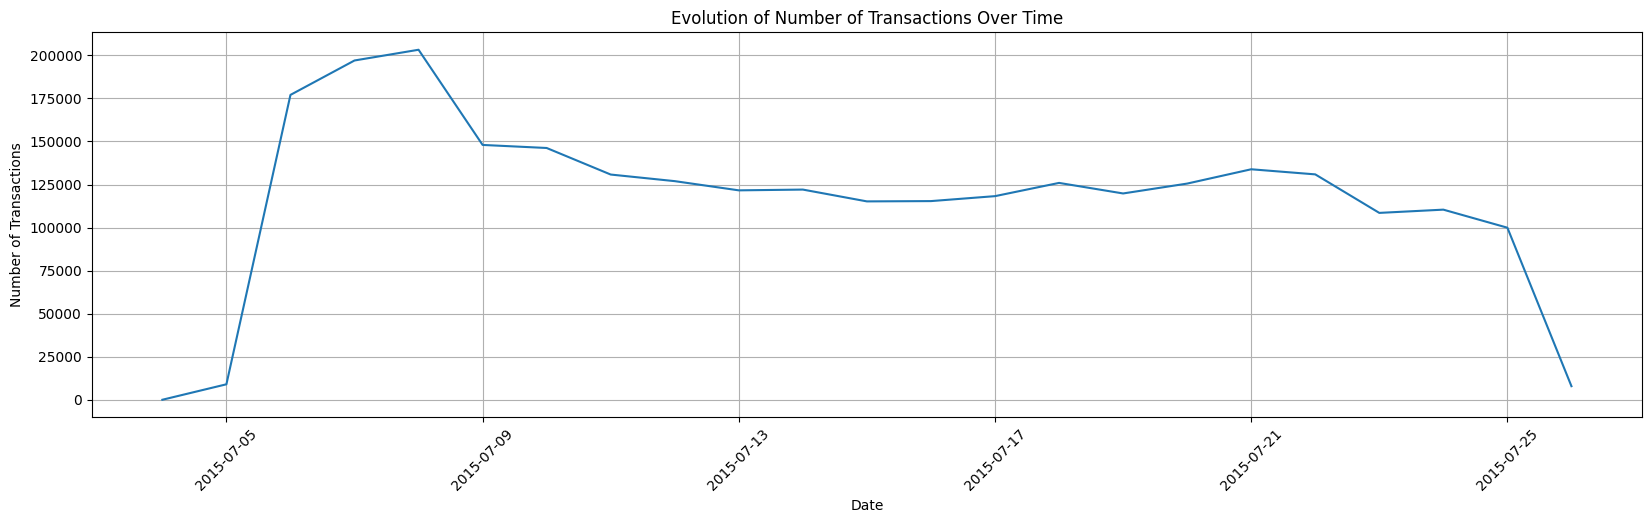

In [ ]:
# Plotting the number of transactions over time
plt.figure(figsize=(20,5))
plt.plot(daily_transaction_count_arr[:,0], daily_transaction_count_arr[:, 1])
plt.title('Evolution of Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


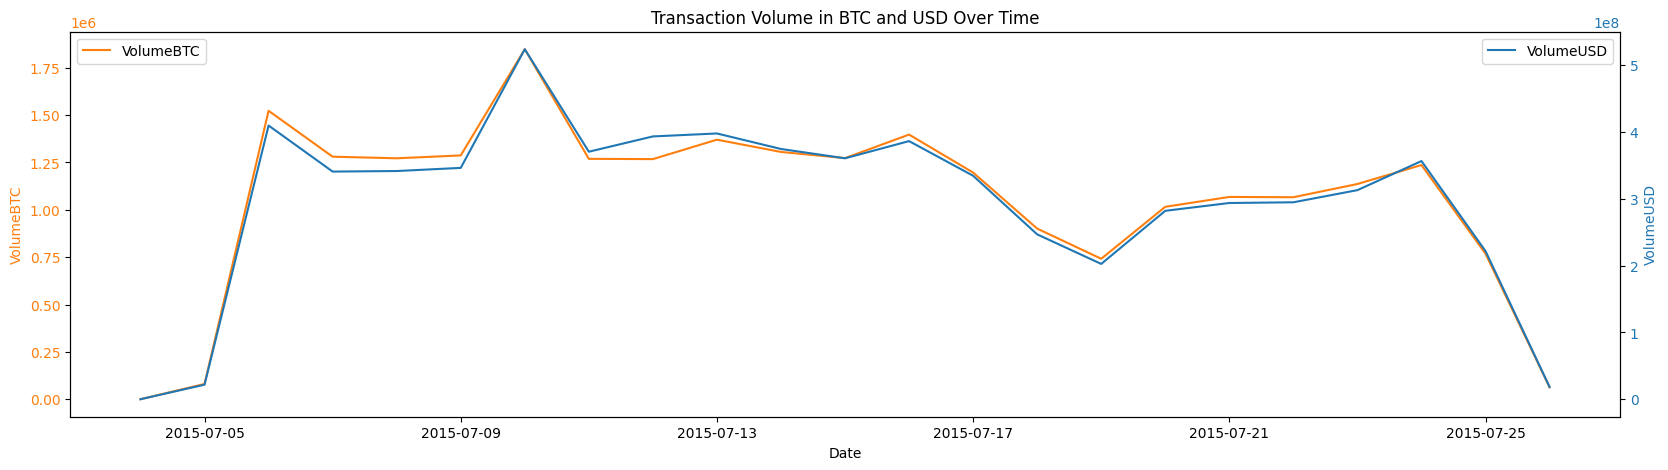

In [ ]:
# Aggregate and convert the data to Pandas DataFrame
volume_btc_arr = np.array(transactionSDF.groupBy("Date").agg(sum("Sum").alias('VolumeBTC')).orderBy("Date").collect())
volume_usd_arr = np.array(transactionSDF.groupBy("Date").agg(sum("USD").alias('VolumeUSD')).orderBy("Date").collect())

# Create a figure and a primary axis
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plot 'VolumeBTC' on the primary y-axis
color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('VolumeBTC', color=color)
ax1.plot(volume_btc_arr[:,0], volume_btc_arr[:,1], color=color, label='VolumeBTC')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for 'VolumeUSD'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('VolumeUSD', color=color)  # we already handled the x-label with ax1
ax2.plot(volume_usd_arr[:,0], volume_usd_arr[:,1], color=color, label='VolumeUSD')
ax2.tick_params(axis='y', labelcolor=color)

# Add a legend and show the plot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Transaction Volume in BTC and USD Over Time')
plt.show()

## Exercise 2 [4 points]

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


In [13]:
# outputDF new column - 'isInInput' defining whether given address is in input and output at the same time (not to treat these cases as transaction receivers)
# this calculation in outputDF will be needed in task 2 and 3 for more complex aggregations
outputDF = outputDF.merge(df[['TxId', 'Input']], how='left', left_on='TxId', right_on='TxId')
outputDF['isInInput'] = outputDF.progress_apply((lambda x: True if x.Output in x.Input else False), axis=1)
outputDF.drop('Input', axis=1, inplace=True)

  0%|          | 0/26393 [00:00<?, ?it/s]

In [ ]:
# selecting a randomg address for testing
sample_address = inputDF.Input.sample().item()

In [15]:
# address account balance retrieval function

def calculate_balance(address):
  '''
  Function that calculates balance of a single address
  '''
  current_balance = 0

  address_outputs = outputDF.loc[(outputDF.Output==address), ['TxId', 'Time', 'Value']]
  address_outputs['Type'] = 1

  address_inputs = inputDF.loc[inputDF.Input==address, ['TxId', 'Time']]
  address_inputs['Type'] = 0

  addressDF = pd.concat([address_inputs, address_outputs]).sort_values(by=['Time', 'TxId', 'Type'], ascending=True).reset_index()

  for index, row in addressDF.iterrows():
      if row.Type == 1:
          current_balance += row.Value
      else:
          current_balance = 0

  return current_balance

In [16]:
# Overal Number of Input / Output transactions - retrieval function

def number_input_output(address: str) -> tuple:
    '''
    Function that calculates the number of transactions in which address appears
    as the input & number of transactions in which address appears as the output
    (excl. cases when address appears in outputDF, but also is in inputDF for
    the given transaction)
    '''
    n_outputs = outputDF[(outputDF.Output == address) &
                         (outputDF.isInInput == False)].TxId.count()
    n_inputs = inputDF[inputDF.Input == sample_address].TxId.count()

    return n_inputs, n_outputs

In [17]:
# maximum input / output transaction per day retrieval function

def max_input_transactions_per_day(address: str) -> tuple:
    addressDF = inputDF[inputDF.Input == sample_address].copy()
    addressDF['Date'] = addressDF.Time.dt.date
    max_number = addressDF.groupby('Date').TxId.count().max()
    max_date = addressDF.groupby('Date').TxId.count().idxmax()
    return max_number, max_date


def max_output_transactions_per_day(address: str) -> tuple:
    addressDF = outputDF[outputDF.Output == sample_address].copy()
    addressDF['Date'] = addressDF.Time.dt.date
    max_number = addressDF.groupby('Date').TxId.count().max()
    max_date = addressDF.groupby('Date').TxId.count().idxmax()
    return max_number, max_date

In [18]:
# total and mean BTC received retrieval function (mean/sum output value)
def total_btc_received(address: str) -> float:
    '''
    Function for calculating the total of bitcoins ever received by a given address.
    The number does not mean balance, but the number of incomming bitcoins.
    Information is calculated from outputDF, by summing all *Values* of transactions,
    where address is not present as input to given transaction.
    '''
    total_received = outputDF[(outputDF.Output == address) &
                              (outputDF.isInInput == False)].Value.sum()
    return total_received


def avg_btc_received(address :str) -> float:
    mean_received = outputDF[(outputDF.Output == address) &
                             (outputDF.isInInput == False)].Value.mean()
    return mean_received

In [20]:
def index_retrieve_string(address: str):

    balance = calculate_balance(address)
    n_inputs, n_outputs = number_input_output(address)
    max_inputs_per_day, max_inputs_date = max_input_transactions_per_day(address)
    max_outputs_per_day, max_outputs_date = max_output_transactions_per_day(address)
    total_received = total_btc_received(address)
    avg_received = avg_btc_received(address)

    output = f'''BTC Address: {address}

----- Address\' statistics -----

current balance: {balance}
transactions sent: {n_inputs}
transactions received: {n_outputs}
maximum number of sent transactions per day: {max_inputs_per_day} (on date: {max_inputs_date})
maximum number of received transactions per day: {max_outputs_per_day} (on date: {max_outputs_date})
total number of BTC received: {total_received} (NOTE: this number doesn\'t include outgoing BTC from the account)
avg number of BTC received: {avg_received}
'''
    print(output)


# priting the index for the sample address
index_retrieve_string(sample_address)

BTC Address: 18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT

----- Address' statistics -----

current balance: 0
transactions sent: 10
transactions received: 3658
maximum number of sent transactions per day: 5 (on date: 2010-07-16)
maximum number of received transactions per day: 3658 (on date: 2010-07-14)
total number of BTC received: 49.9800000000013 (NOTE: this number doesn't include outgoing BTC from the account)
avg number of BTC received: 0.013663203936577719



In [27]:
def index_retrieve_table(address: str):
    balance = calculate_balance(address)
    n_inputs, n_outputs = number_input_output(address)
    max_inputs_per_day, max_inputs_date = max_input_transactions_per_day(address)
    max_outputs_per_day, max_outputs_date = max_output_transactions_per_day(address)
    total_received = total_btc_received(address)
    avg_received = avg_btc_received(address)

    values = ['balance', 'n_inputs', 'n_outputs', 'max_inputs_per_day', 'max_inputs_date', 'max_outputs_per_day', 'max_outputs_date', 'total_received', 'avg_received']

    index_df = pd.DataFrame(data=[[balance, n_inputs, n_outputs, max_inputs_per_day, max_inputs_date, max_outputs_per_day, max_outputs_date, total_received, avg_received]], columns=values, index=[address]).T

    return index_df

index_retrieve_table(sample_address)

,18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT
balance,0
n_inputs,10
n_outputs,3658
max_inputs_per_day,5
max_inputs_date,2010-07-16
max_outputs_per_day,3658
max_outputs_date,2010-07-14
total_received,49.98
avg_received,0.013663


#### Discussion

In scenario, when building website to retrieve statistics, it's crucial to have function that can query the source database when user requests them for a specific address. Unlike in the solution for the next exercise (number 3), in exercise 2, we do not calculate statistics for every address and store them in dataframe with statistics, but instead, we provide functions that at request, calculate statistics for just one address based on current state of source data.

We find it an optimal solution, because in real life database of bitcoin transactions is updated in real time, and after every transaction, we would need to calculate statistics for every account that took part in the transaction. Taking to the account scale of Bitcoin and daily number of transactions, it would require high computational resources and resources for accessing and updating database of statistics all the time, even though, it would be highly probable that most of these statistics would be never retrieved by any user. Therefore, we propose solution, in which statistics are not stored and updated real-time, but only at the request of user per specific requested address.

**Code Explanation: Functions for statistics**
1. Balance Function - filters input and output databases to contain only the ones including the discussed address hash. Combines them chronologicaly, and iterates transaction by transaction to either add to balance based on outputs, or set balance to zero based on inputs.
2. N of inputs/outputs - calculates number of address appearing in rows of outputDF filtered to search among only rows with isInInput == False. For inputs, just counts number of rows
3. Max input/output transactions per day - takes only rows in which address hash apperas. Sroups inputDF and outputDF by date from Time column and then counts number of transaction per date. Returns number of transactions and date.
4. Total/Mean BTC received - total: sums all btc in rows of outputDF, in which address hash appears, and isInInput == False. mean: does the same, but mean aggregation replaces sum (mean is calculated per number of transactions received by account, not being both in inputs and outputs dataframes).

## Exercise 3 [4 points]

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, avergae amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


### Statistics

#### Number of Transactions (incomming and outcomming)

In [ ]:
%%cudf.pandas.profile

# Number of input transactions == Number of transactions Sent
n_input_transactions = inputDF.groupby('Input').TxId.count()

# Number of output transactions == Number of received transactions
# !! -> not accounted as output transaction when when address appears in both inputs and outputs table, because it indicates that given address is a SENDER not RECEIVER
#outputDF = outputDF.merge(inputDF.groupby('TxId')['Input'].progress_apply((lambda x: ast.literal_eval('[' + ','.join('"'+x+'"') + ']'))), how='left', left_on='TxId', right_on='TxId')
outputDF = outputDF.merge(df[['TxId', 'Input']], how='left', left_on='TxId', right_on='TxId')
outputDF['isInInput'] = outputDF.progress_apply((lambda x: True if x.Output in x.Input else False), axis=1)

n_output_transactions = outputDF[outputDF.isInInput == False].groupby('Output').TxId.count()

# Number of transactions (inputs & outputs)
n_transactions = n_input_transactions.reset_index().rename(columns={'TxId':'n_input_trans', 'Input':'Address'}).merge(n_output_transactions.reset_index().rename(columns={'TxId':'n_output_trans', 'Output':'Address'}), how='outer', left_on='Address', right_on='Address').fillna(0)
n_transactions['total_transactions'] = n_transactions.n_input_trans + n_transactions.n_output_trans

n_transactions.to_csv('n_transactions.csv', compression='gzip')

#del n_transactions

#### Current Balance

In [ ]:
def calculate_balances(dataset):
    balances = {}

    for index, row in dataset.iterrows():
        inputs = row['Input']
        outputs = row['Output']

        for input_address in inputs:
            if input_address not in balances:
                balances[input_address] = 0
            balances[input_address] = 0

        for output_address, value in outputs:
            if output_address not in balances:
                balances[output_address] = 0
            balances[output_address] += value

    return balances

account_balances = calculate_balances(df)

account_balance_df = pd.DataFrame(list(account_balances.items()), columns=['Address', 'Balance'])

account_balance_df.sort_values('Balance',ascending=False)
account_balance_df.to_csv('account_balance_df.csv', compression='gzip')

#del account_balance_df

### Average Number of Transaction in Time

#### For overal number of transactions

In [ ]:
input_df_renamed = inputDF[['TxId', 'Time', 'Input']].rename(columns={'Input': 'Address'})
output_df_renamed = outputDF.loc[outputDF.isInInput == False, ['TxId', 'Time', 'Output']].rename(columns={'Output': 'Address'})
combined_df = pd.concat([input_df_renamed, output_df_renamed])

# Converting 'Time' to datetime and extracting date information
combined_df['Time'] = pd.to_datetime(combined_df['Time'])
combined_df['Year'] = combined_df['Time'].dt.year
combined_df['Month'] = combined_df['Time'].dt.month
combined_df['Week'] = combined_df['Time'].dt.isocalendar().week
combined_df['Day'] = combined_df['Time'].dt.day

In [ ]:
# Determine the last date in the dataset
last_transaction_date = combined_df['Time'].max()

# Calculate the earliest transaction dates for each address
earliest_transaction = combined_df.groupby('Address')['Time'].min()

# Calculate the lifespan in days from the first transaction to the last date in the dataset
lifespan_days = (last_transaction_date - earliest_transaction).dt.days
lifespan_days = lifespan_days.apply(lambda x: 1 if x == 0 else x)

# Calculate the first and last transaction timestamps for each address
last_transaction_of_address = combined_df.groupby('Address')['Time'].max()

# Calculate the activity period length in days
activity_period_length = (last_transaction_of_address - earliest_transaction).dt.days.copy()
activity_period_length = activity_period_length.apply(lambda x: x if x != 0 else 1)

# Adjusting the lifespans for weeks, months, and years
# Ensuring a minimum of 1 week, 1 month, and 1 year if there are transactions
lifespan_weeks = np.maximum(lifespan_days / 7, 1)
lifespan_months = np.maximum(lifespan_days / 30, 1)  # Approximation
lifespan_years = np.maximum(lifespan_days / 365, 1)  # Approximation

# Calculate the total number of transactions for each address
total_transactions = combined_df.groupby('Address').size()

# Calculate average frequencies
avg_daily_freq = total_transactions / lifespan_days
avg_weekly_freq = total_transactions / lifespan_weeks
avg_monthly_freq = total_transactions / lifespan_months
avg_yearly_freq = total_transactions / lifespan_years

# Creating a DataFrame to display the results
average_frequencies = pd.DataFrame({
    'Address': total_transactions.index,
    'AvgDailyFreqTotal': avg_daily_freq,
    'AvgWeeklyFreqTotal': avg_weekly_freq,
    'AvgMonthlyFreqTotal': avg_monthly_freq,
    'AvgYearlyFreqTotal': avg_yearly_freq,
    'lifespanDays': lifespan_days
})

average_frequencies['ActivityPeriodLength'] = activity_period_length.reindex(average_frequencies['Address']).values
average_frequencies.reset_index(inplace=True, drop=True)
average_frequencies.to_csv('average_frequencies.csv', compression='gzip')

# del average_frequencies
#average_frequencies.sort_values(by='lifespanDays')

#### For Inputs and Outputs separately (lifespan of addresses remains the same as before)

In [ ]:
# Filter out output transactions where isInInput is True
output_df_filtered = outputDF[outputDF['isInInput'] == False].copy()

# Convert 'Time' to datetime and extract year, month, week, day
inputDF['Time'] = pd.to_datetime(inputDF['Time'])
inputDF['Year'] = inputDF['Time'].dt.year
inputDF['Month'] = inputDF['Time'].dt.month
inputDF['Week'] = inputDF['Time'].dt.isocalendar().week
inputDF['Day'] = inputDF['Time'].dt.day

output_df_filtered['Time'] = pd.to_datetime(output_df_filtered['Time'])
output_df_filtered['Year'] = output_df_filtered['Time'].dt.year
output_df_filtered['Month'] = output_df_filtered['Time'].dt.month
output_df_filtered['Week'] = output_df_filtered['Time'].dt.isocalendar().week
output_df_filtered['Day'] = output_df_filtered['Time'].dt.day

In [ ]:
# Calculate the total number of transactions for each address in input and output
total_transactions_input = inputDF.groupby('Input').size()
total_transactions_output = output_df_filtered.groupby('Output').size()

# Calculate average frequencies using the lifespan values from combined_df
avg_daily_freq_input = total_transactions_input / lifespan_days.reindex(total_transactions_input.index).values
avg_weekly_freq_input = total_transactions_input / lifespan_weeks.reindex(total_transactions_input.index).values
avg_monthly_freq_input = total_transactions_input / lifespan_months.reindex(total_transactions_input.index).values
avg_yearly_freq_input = total_transactions_input / lifespan_years.reindex(total_transactions_input.index).values

avg_daily_freq_output = total_transactions_output / lifespan_days.reindex(total_transactions_output.index).values
avg_weekly_freq_output = total_transactions_output / lifespan_weeks.reindex(total_transactions_output.index).values
avg_monthly_freq_output = total_transactions_output / lifespan_months.reindex(total_transactions_output.index).values
avg_yearly_freq_output = total_transactions_output / lifespan_years.reindex(total_transactions_output.index).values

# Creating DataFrames for the results
average_frequencies_input = pd.DataFrame({
    'Address': total_transactions_input.index,
    'AvgDailyFreqInput': avg_daily_freq_input,
    'AvgWeeklyFreqInput': avg_weekly_freq_input,
    'AvgMonthlyFreqInput': avg_monthly_freq_input,
    'AvgYearlyFreqInput': avg_yearly_freq_input
})

average_frequencies_output = pd.DataFrame({
    'Address': total_transactions_output.index,
    'AvgDailyFreqOutput': avg_daily_freq_output,
    'AvgWeeklyFreqOutput': avg_weekly_freq_output,
    'AvgMonthlyFreqOutput': avg_monthly_freq_output,
    'AvgYearlyFreqOutput': avg_yearly_freq_output
})

# Displaying the head of the DataFrames for verification
#print(average_frequencies_input.head())
#print(average_frequencies_output.head())
#average_frequencies_input.to_csv('average_frequencies_input.csv')
#average_frequencies_output.to_csv('average_frequencies_output.csv')
#del average_frequencies_input
#del average_frequencies_output

#### Largest Number of Transactions in one Day, one Week, one Month & one Year

In [ ]:
# Grouping and counting transactions
input_day_count = inputDF.groupby(['Input', 'Year', 'Month', 'Day']).size()
input_week_count = inputDF.groupby(['Input', 'Year', 'Week']).size()
input_month_count = inputDF.groupby(['Input', 'Year', 'Month']).size()
input_year_count = inputDF.groupby(['Input', 'Year']).size()

output_day_count = output_df_filtered.groupby(['Output', 'Year', 'Month', 'Day']).size()
output_week_count = output_df_filtered.groupby(['Output', 'Year', 'Week']).size()
output_month_count = output_df_filtered.groupby(['Output', 'Year', 'Month']).size()
output_year_count = output_df_filtered.groupby(['Output', 'Year']).size()

# Finding the maximum count
max_input_day = input_day_count.groupby(level=0).max()
max_input_week = input_week_count.groupby(level=0).max()
max_input_month = input_month_count.groupby(level=0).max()
max_input_year = input_year_count.groupby(level=0).max()

max_output_day = output_day_count.groupby(level=0).max()
max_output_week = output_week_count.groupby(level=0).max()
max_output_month = output_month_count.groupby(level=0).max()
max_output_year = output_year_count.groupby(level=0).max()

# Creating DataFrames to display the results
max_input_transactions_df = pd.DataFrame({
    'MaxInputPerDay': max_input_day,
    'MaxInputPerWeek': max_input_week,
    'MaxInputPerMonth': max_input_month,
    'MaxInputPerYear': max_input_year
}).reset_index()

max_output_transactions_df = pd.DataFrame({
    'MaxOutputPerDay': max_output_day,
    'MaxOutputPerWeek': max_output_week,
    'MaxOutputPerMonth': max_output_month,
    'MaxOutputPerYear': max_output_year
}).reset_index()

max_input_transactions_df.rename(columns={'Input':'Address'}, inplace=True)
max_output_transactions_df.rename(columns={'Output':'Address'}, inplace=True)

#max_input_transactions_df.to_csv('max_input_transactions_df.csv')
#max_output_transactions_df.to_csv('max_output_transactions_df.csv')
#del max_input_transactions_df
#del max_output_transactions_df

#### Output Volume

In [ ]:
# Filtering out change transactions from the output dataframe
non_change_outputs = outputDF[outputDF['isInInput'] == False]

# Summing the output volumes for each address, excluding change transactions
non_change_output_volumes = non_change_outputs.groupby('Output')['Value'].sum()

# Creating a dataframe for non-change output volumes
non_change_output_volumes_df = pd.DataFrame(non_change_output_volumes).reset_index()
non_change_output_volumes_df.rename(columns={'Output': 'Address', 'Value': 'TotalNonChangeOutputVolume'}, inplace=True)

non_change_output_volumes_df.sort_values(by="TotalNonChangeOutputVolume", ascending=False)
non_change_output_volumes_df.to_csv('non_change_output_volumes_df.csv', compression='gzip')

#del non_change_output_volumes_df

#### Number of Unique counterparties

In [ ]:
# Create mappings from TxId to unique input and output addresses
input_txid_to_addresses = inputDF.groupby('TxId')['Input'].unique()
output_txid_to_addresses = output_df_filtered.groupby('TxId')['Output'].unique()

# Function to aggregate unique counterparties for input
def aggregate_unique_input_counterparties(tx_ids):
    unique_addresses = set()
    for tx_id in tx_ids:
        unique_addresses.update(output_txid_to_addresses.get(tx_id, []))
    return len(unique_addresses)

# Function to aggregate unique counterparties for output
def aggregate_unique_output_counterparties(tx_ids):
    unique_addresses = set()
    for tx_id in tx_ids:
        unique_addresses.update(input_txid_to_addresses.get(tx_id, []))
    return len(unique_addresses)

# Calculating unique counterparties for each address
unique_input_counterparties = inputDF.groupby('Input')['TxId'].progress_apply(aggregate_unique_input_counterparties)
unique_output_counterparties = output_df_filtered.groupby('Output')['TxId'].progress_apply(aggregate_unique_output_counterparties)

# Create a list of all unique addresses from both input and output dataframes
all_addresses = pd.Series(list(set(inputDF['Input']).union(set(output_df_filtered['Output']))))

# Reindex the unique counterparties series to align with the list of all addresses
unique_input_counterparties_reindexed = unique_input_counterparties.reindex(all_addresses, fill_value=0)
unique_output_counterparties_reindexed = unique_output_counterparties.reindex(all_addresses, fill_value=0)

# Create the final DataFrame using the reindexed series
unique_counterparties_df = pd.DataFrame({
    'Address': all_addresses,
    'InputUniqueCounterparties': unique_input_counterparties_reindexed.values,
    'OutputUniqueCounterparties': unique_output_counterparties_reindexed.values
})

unique_counterparties_df.head()

#unique_counterparties_df.to_csv('unique_counterparties_df.csv')

#### Transaction Volume -> Average overal value of Transactions in which an account took part
what if a single account takes part in transactions which are super big, either as the input or as the output (Calculated together)

In [ ]:
transaction_values_df = outputDF[outputDF.isInInput==True].groupby('TxId').agg({'Sum':'first','Time':'first','Value': 'sum'}).rename(columns={'Sum':'Input', 'Value':'Returned', 'Time':'Date'})
transaction_values_df.Date = pd.to_datetime(transaction_values_df.Date.dt.date)
transaction_values_df = transaction_values_df.reset_index().merge(priceDF, how='left', left_on='Date', right_on='Date')

transactions_unique_df = outputDF.groupby('TxId')[['Sum', 'isInInput', 'Time']].agg({'isInInput':'sum', 'Sum':'first', 'Time':'first'})
transactions_unique_df['Returned'] = 0
transactions_unique_df.Time = pd.to_datetime(transactions_unique_df.Time.dt.date)
transactions_unique_df.rename(columns={'Sum':'Input', 'Time':'Date'}, inplace=True)
transactions_unique_df = transactions_unique_df.reset_index().merge(priceDF, how='left', left_on='Date', right_on='Date')

transaction_values_df = pd.concat([transaction_values_df, transactions_unique_df.loc[transactions_unique_df.isInInput == 0, ['TxId', 'Input','Returned','Date', 'Price']]])
transaction_values_df.reset_index(inplace=True)

transaction_values_df['TransVolumeBTC'] = transaction_values_df.Input - transaction_values_df.Returned
transaction_values_df['TransVolumeUSD'] = transaction_values_df.TransVolumeBTC*transaction_values_df.Price

In [ ]:
avg_trans_volume_df = combined_df.merge(transaction_values_df[['TxId', 'TransVolumeBTC', 'TransVolumeUSD']], how='outer', left_on = 'TxId', right_on='TxId').groupby('Address')[['TransVolumeBTC', 'TransVolumeUSD']].mean().reset_index().rename(columns={'TransVolumeBTC':'AvgTransVolumeBTC', 'TransVolumeBTC':'AvgTransVolumeBTC'}).copy()
avg_trans_volume_df.to_csv('avg_trans_volume_df.csv')
#del avg_trans_volume_df

#### Number of self-transfers

In [ ]:
outputDF['lenInput'] = outputDF.Input.apply(len)
self_transfers_count_df = outputDF[(outputDF.isInInput == True) & (outputDF.Value == outputDF.Sum) & (outputDF.lenInput == 1)].groupby('Output').size().reset_index().rename(columns={'Output':'Address', 0:'nSelfTransfers'})

self_transfers_count_df.to_csv('self_transfers_count_df.csv', compression='gzip')
del self_transfers_count_df

In [ ]:
final_df = pd.merge(n_transactions, account_balance_df, on='Address', how='left')
final_df = pd.merge(final_df, average_frequencies, on='Address', how='left')
final_df = pd.merge(final_df, average_frequencies_input, on='Address', how='left')
final_df = pd.merge(final_df, average_frequencies_output, on='Address', how='left')
final_df = pd.merge(final_df, max_input_transactions_df, on='Address', how='left')
final_df = pd.merge(final_df, max_output_transactions_df, on='Address', how='left')
final_df = pd.merge(final_df, non_change_output_volumes_df, on='Address', how='left')
final_df = pd.merge(final_df, unique_counterparties_df, on='Address', how='left')
final_df = pd.merge(final_df, avg_trans_volume_df, on='Address', how='left')
final_df = pd.merge(final_df, self_transfers_count_df, on='Address', how='left')

final_df.head()
final_df.to_csv('finalDF.csv', compression='gzip')

In [ ]:
final_df.columns

#### Discussion - statistics and feature engineering

**Statistics Calculated:**
1. Current Balance
2. Average Number Of Transactions in time (daily, weekly, monthly, yearly)<ul><li>For overal number of transactions</li><li>For input transctions</li><li>for output transctions only</li></ul>
3. address lifespan and address activity period
4. Max number of transactions in time (daily, weekly, monthly, yearly) - separately for inputs and outputs (e.g. max number of input transactions per day, max number of output transctions per month)
5. Total number of BTC received by each address - excluding returning BTC when the address was also in the inputDF
6. Unique counterparties (separately for inputs and outputs) - number of unique address with which each address interacted by either receiving from or sending to.
7. Transaction volume (BTC and USD) - overal volume of all transactions that address took part in either as input or as output. This indicator measures the overall size of all transactions in which address was involced. Calculated for BTC and USD, to account for fluctuations in BTC price.
7. Number of self-transfers - number of transactions in which the same address was the only input and only output. Such transactions may be used for portfolio optimisation or making it harder to track individual BTC addresses and individual transactions.

**Comments**

While all calculations gave significant number of statistics, due to computational limitations of Google Colab, and limitation to only one large dataset, they are partially miscalculated, or follow false assumptions.

The dataset used in the whole analysis '364001-367000.csv.gz' consists of data from only few weeks. Hence, lifespan and activity period calculations are not valid entirely valid, as they only account for this short timeframe. Therefore, all aggregations per week/month/year do not give vital informations. Only aggregations per day can be somewhat used in further analysis. This fact significantly shrinks the available statistics for further modeling and clustering.

### Labels + Processing

In [ ]:
TXDATA_FILE_LARGE

'364001-367000.csv.gz'

In [ ]:
labels_df = pd.read_csv(f'drive/MyDrive/Colab Notebooks/NOVA/sbe2324ada/labels/labels-{TXDATA_FILE_LARGE}')

In [ ]:
labels_df.type.value_counts()


service      449354
exchanges    108367
historic      59680
gambling      49467
mining          709
Name: type, dtype: int64

dataset with addresses and statistics is loaded from a file available at this link: https://drive.google.com/file/d/1yU8iWzVSMofraZXWS0xZ_Pv6pMaaEI5W/view?usp=sharing
<br>The reason for loading the file, instead of proceeding with file calculated above is that we were running the notebook multiple times and didn't want to waste time on computing the same dataset multiple times.

In [ ]:
final_df = pd.read_csv('drive/MyDrive/Colab Notebooks/NOVA/final_df.csv.gz', index_col=0)

In [ ]:
final_df.head()

,Address,n_input_trans,n_output_trans,total_transactions,Balance,AvgDailyFreqTotal,AvgWeeklyFreqTotal,AvgMonthlyFreqTotal,AvgYearlyFreqTotal,lifespanDays,...,MaxOutputPerDay,MaxOutputPerWeek,MaxOutputPerMonth,MaxOutputPerYear,TotalNonChangeOutputVolume,InputUniqueCounterparties,OutputUniqueCounterparties,AvgTransVolume,nSelfTransfers,TransVolumeUSD
0,111111U5LFqTauauVpCvdd2nDeUHx6Nh,1.0,0.0,1.0,0.000000,0.125000,0.875000,1.0,1.0,8,...,NaN,NaN,NaN,NaN,NaN,2,0,0.002244,NaN,0.627492
1,11112Q6fH8R8oDssqvU3wg8RgwGSLf7ni,1.0,1.0,2.0,0.000000,0.111111,0.777778,2.0,2.0,18,...,1.0,1.0,1.0,1.0,0.008476,1,1,0.008521,NaN,2.268359
2,11116n3FtiFDohakQHSFfv9YNq8nkMXEV,9.0,30.0,39.0,39.459363,2.785714,19.500000,39.0,39.0,14,...,2.0,14.0,30.0,30.0,257.282679,12,43,59.241231,NaN,16809.828504
3,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,1.0,54.0,55.0,0.000000,3.928571,27.500000,55.0,55.0,14,...,19.0,51.0,54.0,54.0,0.013517,1,10,0.000489,NaN,0.140128
4,11121EdiswnM3MMSTj8hcrKoPmdwdVjEqZ,1.0,1.0,2.0,0.000000,0.105263,0.736842,2.0,2.0,19,...,1.0,1.0,1.0,1.0,0.014025,2,2,0.411626,NaN,110.768510


In [ ]:
# checking null values -> most of them make sense due to left joins and can be replaced with 0

final_df.isnull().sum()

Address                             0
n_input_trans                       0
n_output_trans                      0
total_transactions                  0
Balance                             0
AvgDailyFreqTotal                   0
AvgWeeklyFreqTotal                  0
AvgMonthlyFreqTotal                 0
AvgYearlyFreqTotal                  0
lifespanDays                        0
ActivityPeriodLength                0
AvgDailyFreqInput              415285
AvgWeeklyFreqInput             415285
AvgMonthlyFreqInput            415285
AvgYearlyFreqInput             415285
AvgDailyFreqOutput             242991
AvgWeeklyFreqOutput            242991
AvgMonthlyFreqOutput           242991
AvgYearlyFreqOutput            242991
MaxInputPerDay                 415285
MaxInputPerWeek                415285
MaxInputPerMonth               415285
MaxInputPerYear                415285
MaxOutputPerDay                242991
MaxOutputPerWeek               242991
MaxOutputPerMonth              242991
MaxOutputPer

In [ ]:
final_df = final_df.fillna(0)

In [ ]:
labels_df.address = labels_df.address.apply(ast.literal_eval)

In [ ]:
final_df = final_df.merge(labels_df[['address', 'type']].rename(columns={'address':'Address'}), how='left', left_on='Address', right_on='Address')

In [ ]:
final_df['type'].value_counts()

service      449354
exchanges    108367
historic      59680
gambling      49467
mining          709
Name: type, dtype: int64

In [ ]:
final_df['type'] = final_df['type'].fillna('no_label')

In [ ]:
final_df['type'].value_counts()

no_label     3246863
service       449354
exchanges     108367
historic       59680
gambling       49467
mining           709
Name: type, dtype: int64

### Feature Selection

**Important Comment on Feature Selection**:

Knowing how imbalanced the labels (no_label accounts for over 80% of whole dataset), the feature selection and further modeling will be performed separately for two variants of the data:
1. Whole dataset - including rows tagged as 'no_label'
2. Only labeled data - excluding rows tagged as 'no_labels'

The assumption for variant 2, is that rows without a label found in the labels dataset, can indeed fall into one of the defined groups (labels), but were not identified by the entities providing the labels. Hence, we should focus only on classifying these labels. With this assumption in mind, in the end, a well-performing classification model trained on labels-only dataset could be applied to all rows that do not have a label, to predict the labels and identify new groups of observations with specific labels.

####Feature Selection for dataset with all observations

To rank relevance of each feature on the label column, we perform ANOVA analysis, in order to see which features have the biggest variance among all labels. This is performed separarely for dataset including and excluding 'no_label' obesrvations.

In [ ]:
features = final_df.iloc[:,1:-1].copy().to_numpy()
target = final_df.iloc[:,-1].to_numpy()

In [ ]:
from sklearn.feature_selection import f_classif
#from sklearn.preprocessing import LabelEncoder

# Encoding the categorical target variable if it's not numeric
le = LabelEncoder()
y_encoded = le.fit_transform(target)

# Apply ANOVA F-test
f_values, p_values = f_classif(features, y_encoded)

# Creating a DataFrame to display F-values and p-values for each feature
anova_results = pd.DataFrame({'Feature': final_df.columns[1:-1], 'F-value': f_values, 'p-value': p_values})

# Sorting the results by F-value in descending order
anova_results_sorted = anova_results.sort_values(by='F-value', ascending=False)

In [ ]:
anova_results_sorted

,Feature,F-value,p-value
31,TransVolumeUSD,45061.205258,0.000000e+00
29,AvgTransVolume,44049.021266,0.000000e+00
8,lifespanDays,8776.832383,0.000000e+00
9,ActivityPeriodLength,6354.458905,0.000000e+00
27,InputUniqueCounterparties,5804.751026,0.000000e+00
28,OutputUniqueCounterparties,825.297809,0.000000e+00
10,AvgDailyFreqInput,413.183339,0.000000e+00
11,AvgWeeklyFreqInput,211.045761,7.108102e-226
18,MaxInputPerDay,159.727886,2.372370e-170
0,n_input_trans,150.734973,1.257572e-160


**important!** - while selecting features based on F-Score, we discard some features despite of their high F-Score, due to logic explained before connected to limitations of the dataset (short timeframe). Due to this reason, we won't take into the account Weekly / Monthly / Annual aggregations as well as lifespan or activity period length. Instead, we select several features with statistically significant F-Score, that also follow the logic described above.

In [ ]:
selected_features = ['TransVolumeUSD', 'InputUniqueCounterparties', 'OutputUniqueCounterparties', 'AvgDailyFreqInput', 'MaxInputPerDay', 'MaxOutputPerDay', 'AvgDailyFreqOutput']

####Feature Selection for dataset consiting of only observations with a label assigned (excl. no-label)

In [ ]:
features_only_labels = final_df[final_df.type != 'no_label'].iloc[:,1:-1].to_numpy()
target_only_labels = final_df[final_df.type != 'no_label'].iloc[:,-1].to_numpy()

In [ ]:
y_encoded = le.fit_transform(target_only_labels)

f_values, p_values = f_classif(features_only_labels, y_encoded)

# Creating a DataFrame to display F-values and p-values for each feature
anova_results = pd.DataFrame({'Feature': final_df.columns[1:-1], 'F-value': f_values, 'p-value': p_values})

# Sorting the results by F-value in descending order
anova_results_sorted = anova_results.sort_values(by='F-value', ascending=False)

In [ ]:
anova_results_sorted

,Feature,F-value,p-value
31,TransVolumeUSD,12571.779685,0.000000e+00
29,AvgTransVolume,12507.444879,0.000000e+00
9,ActivityPeriodLength,6100.588114,0.000000e+00
8,lifespanDays,4445.240658,0.000000e+00
27,InputUniqueCounterparties,712.826785,0.000000e+00
3,Balance,126.967766,1.462950e-108
28,OutputUniqueCounterparties,89.963660,1.370512e-76
26,TotalNonChangeOutputVolume,78.877289,5.067157e-67
10,AvgDailyFreqInput,8.746844,4.675082e-07
4,AvgDailyFreqTotal,8.194804,1.325953e-06


In [ ]:
selected_features_labels_only = ['TransVolumeUSD', 'InputUniqueCounterparties', 'Balance', 'OutputUniqueCounterparties', 'TotalNonChangeOutputVolume', 'AvgDailyFreqInput']

## Modeling



#### KNN - classification including rows with 'no_label'

#### Grid Search for Optimal KNN parameters

**Important comment on GridSearchCV**

Due to computational limitations, subset of addresses was choosen (n=100.000). The subset will be used to compute best parameters for the model with GridSearchCV. Further, the best parameters will be saved and model with these parameters will be trained on the whole dataset (not just sample of size n).

***This will be applied separately for datasets with and without 'no_labels'***

In [ ]:
from sklearn.model_selection import train_test_split
from cuml.neighbors import KNeighborsClassifier
from cuml.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score
from cuml.model_selection import GridSearchCV
from cuml.preprocessing import StandardScaler

In [ ]:
sample_size = 100000

_, sample_df = train_test_split(final_df, stratify=final_df['type'], test_size=sample_size / len(final_df), random_state=2137)


In [ ]:
sample_df.to_csv('drive/MyDrive/Colab Notebooks/NOVA/sample_df.csv.gz', compression='gzip')

In [ ]:
sample_df = pd.read_csv('drive/MyDrive/Colab Notebooks/NOVA/sample_df.csv.gz', compression='gzip')

In [ ]:
features_sample = sample_df.loc[:,selected_features].to_numpy()
target_sample = sample_df.iloc[:,-1].to_numpy()
x_train_sample, x_test_sample, y_train_sample, y_test_sample = train_test_split(features_sample, target_sample, test_size = 0.20, random_state=2137, stratify=target_sample)

y_train_sample_encoded = le.fit_transform(y_train_sample)

In [ ]:
from cuml.model_selection import GridSearchCV

scaler = StandardScaler()
x_train_sample_std = scaler.fit_transform(x_train_sample)
x_test_sample_std = scaler.transform(x_test_sample)

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']#,
    #'algorithm': ['ball_tree', 'kd_tree', 'brute']
    # Include more parameters and values as needed
}

# Create KNN model
knn = KNeighborsClassifier()

# Create GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(x_train_sample_std.get(), y_train_sample_encoded)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [ ]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}

In [ ]:
knn_1 = grid_search.best_estimator_

In [ ]:
y_pred_sample = knn_1.predict(x_test_sample_std.get())

In [ ]:
y_test_np = np.array(le.transform(y_test_sample))
y_pred_np = y_pred_sample

accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np, average='macro')
recall = recall_score(y_test_np, y_pred_np, average='macro')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.9036
Precision: 0.5659587151381326
Recall: 0.36373853313336824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Fitting Model with found optimal parameters on the whole dataset

In [ ]:
features = final_df.loc[:,selected_features].to_numpy()
target = final_df.iloc[:,-1].to_numpy()

x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(features, target, test_size = 0.20, random_state=2137, stratify=target)

y_train_full_encoded = le.fit_transform(y_train_full)

In [ ]:
from cuml.neighbors import KNeighborsClassifier
scaler = StandardScaler()
x_train_full_std = scaler.fit_transform(x_train_full)
x_test_full_std = scaler.transform(x_test_full)

knn = KNeighborsClassifier(n_neighbors=7, distance='manhattan', weights='uniform')
knn.fit(x_train_full_std, y_train_full_encoded)
y_pred = knn.predict(x_test_full_std)

[I] [12:13:03.000366] Unused keyword parameter: distance during cuML estimator initialization


In [ ]:
y_test_full_np = np.array(le.transform(y_test_full))
y_pred_full_np = y_pred.get()

accuracy = accuracy_score(y_test_full_np, y_pred_full_np)
precision = precision_score(y_test_full_np, y_pred_full_np, average='macro')
recall = recall_score(y_test_full_np, y_pred_full_np, average='macro')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.9052252684930667
Precision: 0.6641711079033448
Recall: 0.4124541888502847


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(le.inverse_transform(y_test_full_np), le.inverse_transform(y_pred_full_np)))

              precision    recall  f1-score   support

   exchanges       0.46      0.14      0.22     21673
    gambling       0.38      0.03      0.06      9893
    historic       0.69      0.41      0.51     11936
      mining       0.70      0.13      0.22       142
    no_label       0.92      0.97      0.95    649373
     service       0.82      0.79      0.80     89871

    accuracy                           0.91    782888
   macro avg       0.66      0.41      0.46    782888
weighted avg       0.89      0.91      0.89    782888



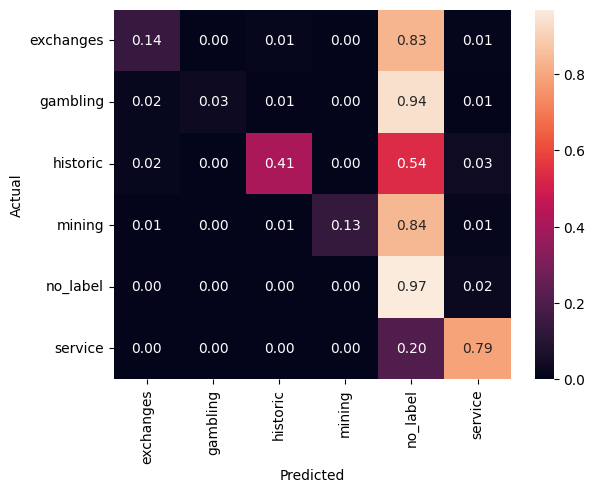

In [ ]:
cm = confusion_matrix(le.inverse_transform(y_test_full_np), le.inverse_transform(y_pred_full_np))

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#### Modeling Results KNN on the whole dataset (incl. 'no_label')

As we can see, the accuracy of the KNN model with GridSearchCV calculated parameters reaches almost 90% on the test dataset. This might indicate good performance. However, after closer examination of Precision, Recall and Confusion Matrix, we can see, that the model performs well only on classes 'no_label' and 'service' due to their high presence of the dataset, and keeps classifying other labels most of the times as 'no_label', which significantly lowers the precision score.

**This approach does not result with a well performing model**

### KNN for dataset excl. no_label

#### GridSearch

In [ ]:
sample_size = 100000

_, sample_df = train_test_split(final_df[final_df.type != 'no_label'],
                                stratify=final_df.loc[(final_df.type!='no_label'),'type'],
                                test_size=sample_size / len(final_df[final_df.type != 'no_label']),
                                random_state=2137
                                )

In [ ]:
sample_df.to_csv('drive/MyDrive/sample_df_only_labels.csv.gz', compression='gzip')

In [ ]:
sample_df = pd.read_csv('drive/MyDrive/sample_df_only_labels.csv.gz', compression='gzip', index_col=0)

In [ ]:
features_sample = sample_df.loc[:,selected_features_labels_only].to_numpy()
target_sample = sample_df.iloc[:,-1].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(features_sample, target_sample, test_size = 0.20, random_state=2137, stratify=target_sample)

scaler = StandardScaler()

x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

y_train_encoded = le.fit_transform(y_train)

In [ ]:
from cuml.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']#,
    #'algorithm': ['ball_tree', 'kd_tree', 'brute']
    # Include more parameters and values as needed
}

# Create KNN model
knn = KNeighborsClassifier()

# Create GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=2)

In [ ]:
grid_search.fit(x_train_std, y_train_encoded)

[I] [11:45:28.663242] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[I] [11:45:28.683317] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=  10.6s
[I] [11:45:39.316626] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[I] [11:45:39.424350] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[I] [11:45:39.537200] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.1s
[I] [11:45:39.615635] Unused keyword parameter: n_jobs during cuML estimator initialization
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; t

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [ ]:
knn_3 = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}

In [ ]:
y_pred = knn_3.predict(x_test_std)

In [ ]:
y_test_np = np.array(le.transform(y_test))
y_pred_np = y_pred.get()

accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np, average='macro')
recall = recall_score(y_test_np, y_pred_np, average='macro')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.8316
Precision: 0.7003115958163704
Recall: 0.596771760398152


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(le.inverse_transform(y_test_np), le.inverse_transform(y_pred_np)))

              precision    recall  f1-score   support

   exchanges       0.62      0.72      0.66      3247
    gambling       0.51      0.48      0.49      1482
    historic       0.72      0.62      0.67      1788
      mining       0.71      0.24      0.36        21
     service       0.94      0.93      0.93     13462

    accuracy                           0.83     20000
   macro avg       0.70      0.60      0.62     20000
weighted avg       0.84      0.83      0.83     20000



#### Fitting on whole dataset, with optimal parameters according to GridSearch

In [ ]:
features = final_df[final_df.type != 'no_label'].loc[:, selected_features_labels_only].copy().to_numpy()
target = final_df[final_df.type != 'no_label'].iloc[:,-1].to_numpy()

x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(features, target, test_size = 0.20, random_state=2137, stratify=target)

scaler = StandardScaler()
x_train_full_std = scaler.fit_transform(x_train_full)
x_test_full_std = scaler.transform(x_test_full)

y_train_full_encoded = le.fit_transform(y_train_full)

In [ ]:
knn_4 = KNeighborsClassifier(n_neighbors=10, distance='manhattan', weights='uniform')
knn_4.fit(x_train_full_std, y_train_full_encoded)

[I] [11:48:51.340310] Unused keyword parameter: distance during cuML estimator initialization


KNeighborsClassifier()

In [ ]:
y_pred = knn_4.predict(x_test_full_std)

In [ ]:
y_test_full_np = np.array(le.transform(y_test_full))
y_pred_full_np = y_pred.get()

accuracy = accuracy_score(y_test_full_np, y_pred_full_np)
precision = precision_score(y_test_full_np, y_pred_full_np, average='macro')
recall = recall_score(y_test_full_np, y_pred_full_np, average='macro')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.813730189640193
Precision: 0.6946376718133784
Recall: 0.5889616645624305


In [ ]:
print(classification_report(le.inverse_transform(y_test_full_np), le.inverse_transform(y_pred_full_np)))

              precision    recall  f1-score   support

   exchanges       0.62      0.65      0.64     21674
    gambling       0.44      0.38      0.40      9893
    historic       0.71      0.60      0.65     11936
      mining       0.80      0.39      0.52       142
     service       0.91      0.93      0.92     89871

    accuracy                           0.81    133516
   macro avg       0.69      0.59      0.63    133516
weighted avg       0.81      0.81      0.81    133516



In [ ]:
cm = confusion_matrix(le.inverse_transform(y_test_full_np), le.inverse_transform(y_pred_full_np))

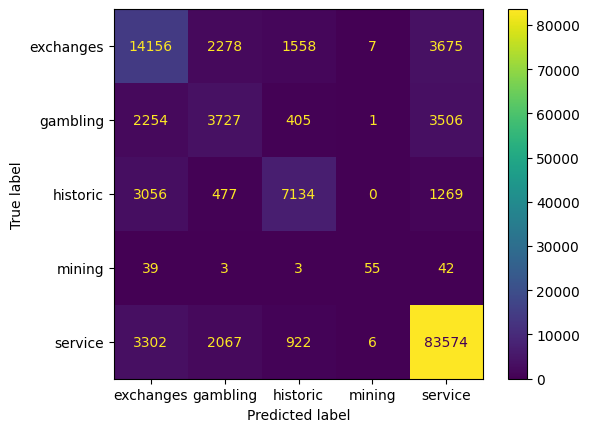

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)

cm_display.plot()
plt.show()

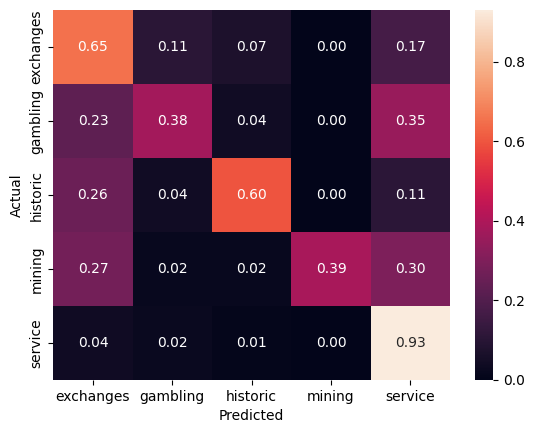

In [ ]:
# Normalised confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#### Training on the whole dataset + 10-Fold cross validation performance metrics

Cross Validation is not yet implemented in cuML, so Sklearn Library is needed for this purpose

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score, make_scorer

scaler = StandardScaler()
features_std = scaler.fit_transform(features)

knn_5 = KNeighborsClassifier(n_neighbors=10, metric='manhattan', weights='uniform')

acc_scorer = make_scorer(accuracy_score)
b_acc_scorer = make_scorer(balanced_accuracy_score)
rec_scorer = make_scorer(recall_score, average='macro')
prec_scorer = make_scorer(precision_score, average='macro')

cv_score = cross_validate(estimator = knn_5,
                          X=features_std.get(),
                          y=le.fit_transform(target),
                          cv=10, verbose=1,
                          scoring={'acc':acc_scorer, 'b_acc':b_acc_scorer, 'rec':rec_scorer, 'prec':prec_scorer})

In [ ]:
print(
f'''
Metrics of KNN model trained on the whole dataset, based on 10-Fold cross validation
accuracy: {cv_score['test_acc'].mean().round(3)}
balanced accuracy: {cv_score['test_b_acc'].mean().round(3)}
recall: {cv_score['test_rec'].mean().round(3)}
precision: {cv_score['test_prec'].mean().round(3)}
'''
)


Metrics of KNN model trained on the whole dataset, based on 10-Fold cross validation
accuracy: 0.825
balanced accuracy: 0.629
recall: 0.629
precision: 0.724



#### Modeling Results KNN on the whole dataset (incl. 'no_label')

Applying the same strategy on the dataset excluding 'no_label' observations appears to yeald significantly petter results then previous approach.

As we can observe, accuracy on the training data shrinked to 81%, however precision and recall significantly grew to 0.69 and 0.59 respectively (from 0.55 and 0.37). Taking to the account, that the training dataset, even when applying full dataset '364001-367000.csv.gz', represents just a fraction of all BTC transaction related data (only few weeks), we can expect the applied strategy with KNN, GridSearchCV on sample of the dataset (to define parameters) to yeld significantly high results when training on the whole available bitcoin transactions data.

To minimize the effect of randomness from Train/Test split, we also implemented model evaluation if it was trained on the whole dataset. Performance metrics were calculated with 10-Fold cross validation. The final KNN model achieved 0.63 of balanced accuracy (0.825 of accuracy), 0.63 of recall and 0.72 of precision. These unbiased scores indicate that the overall performance of the KNN model on all classes is not the best, however, the metrics are less biased by the randomness introduced with train-test split.

PCA analysis of classification test results

In [ ]:
le.inverse_transform(y_test_full_np)

array(['service', 'service', 'gambling', ..., 'service', 'exchanges',
       'service'], dtype=object)

In [ ]:
# Both import methods supported
from cuml import PCA
from cuml.preprocessing import StandardScaler

s = StandardScaler()

data_std = s.fit_transform(x_test_full)

pca = PCA(n_components = 2)
components = pca.fit_transform(data_std)

In [ ]:
pc1 = components[:, 0].get()
pc2 = components[:, 1].get()

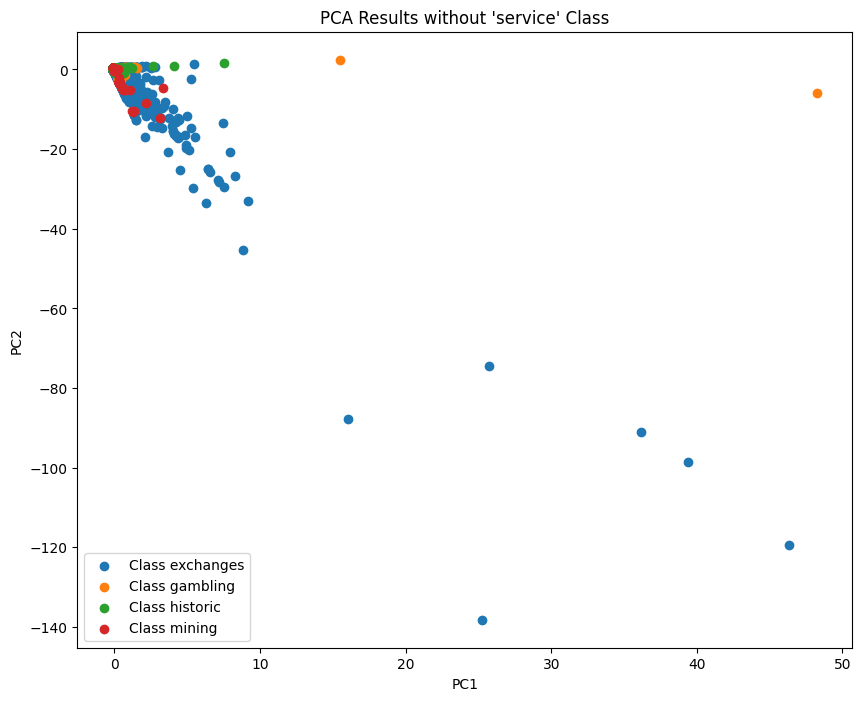

In [ ]:
filter_mask = le.inverse_transform(y_pred_full_np) != 'service'

PC1_no_service = pc1[filter_mask]
PC2_no_service  = pc2[filter_mask]
classes_filtered_no_service = le.inverse_transform(y_pred_full_np)[filter_mask]

# Create a scatter plot without the 'no_label' class
plt.figure(figsize=(10, 8))
for class_value in np.unique(classes_filtered_no_service):
    # Select indices for data points of the current class
    idx = classes_filtered_no_service == class_value

    # Plot data points of this class
    plt.scatter(PC1_no_service [idx], PC2_no_service [idx], label=f'Class {class_value}')

# Adding title and labels
plt.title('PCA Results without \'service\' Class')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add a legend to show class labels
plt.legend()

# Show plot
plt.show()

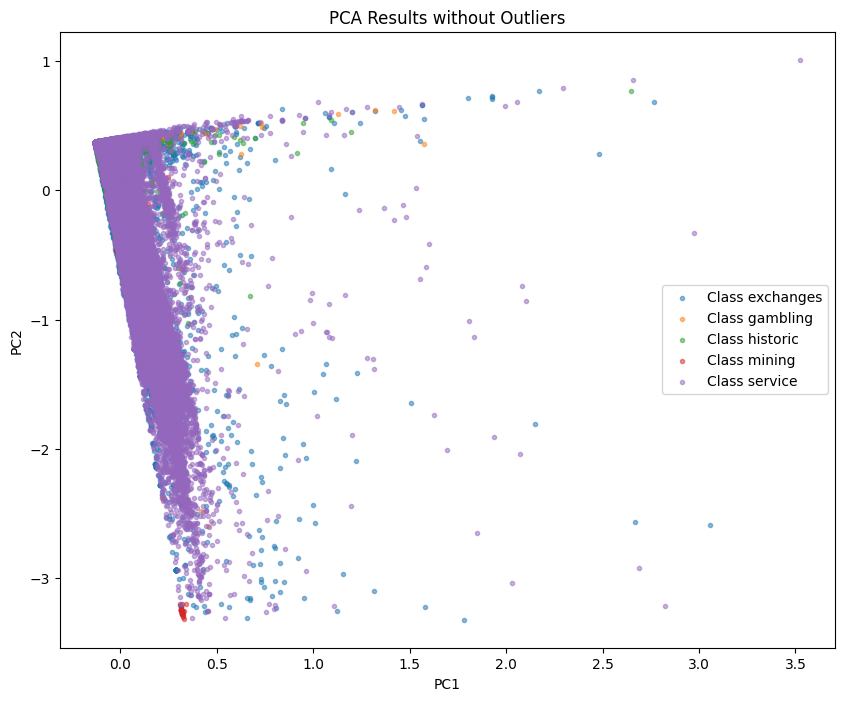

In [ ]:
from scipy import stats

# Remove outliers based on PC1 and PC2
z_scores_pc1 = np.abs(stats.zscore(pc1))
z_scores_pc2 = np.abs(stats.zscore(pc2))

# Set a threshold for outlier detection (usually a z-score of 3 or more is considered an outlier)
threshold = 3

# Find indices where both PC1 and PC2 are not outliers
non_outliers = (z_scores_pc1 < threshold) & (z_scores_pc2 < threshold)

# Filter data to remove outliers
PC1_filtered = pc1[non_outliers]
PC2_filtered = pc2[non_outliers]
classes_filtered = le.inverse_transform(y_pred_full_np)[non_outliers]

# Create a scatter plot without outliers
plt.figure(figsize=(10, 8))
for class_value in np.unique(classes_filtered):
    # Select indices for data points of the current class
    idx = classes_filtered == class_value

    # Plot data points of this class
    plt.scatter(PC1_filtered[idx], PC2_filtered[idx], label=f'Class {class_value}', marker='.', alpha=0.5)

# Adding title and labels
plt.title('PCA Results without Outliers')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add a legend to show class labels
plt.legend()

# Show plot
plt.show()

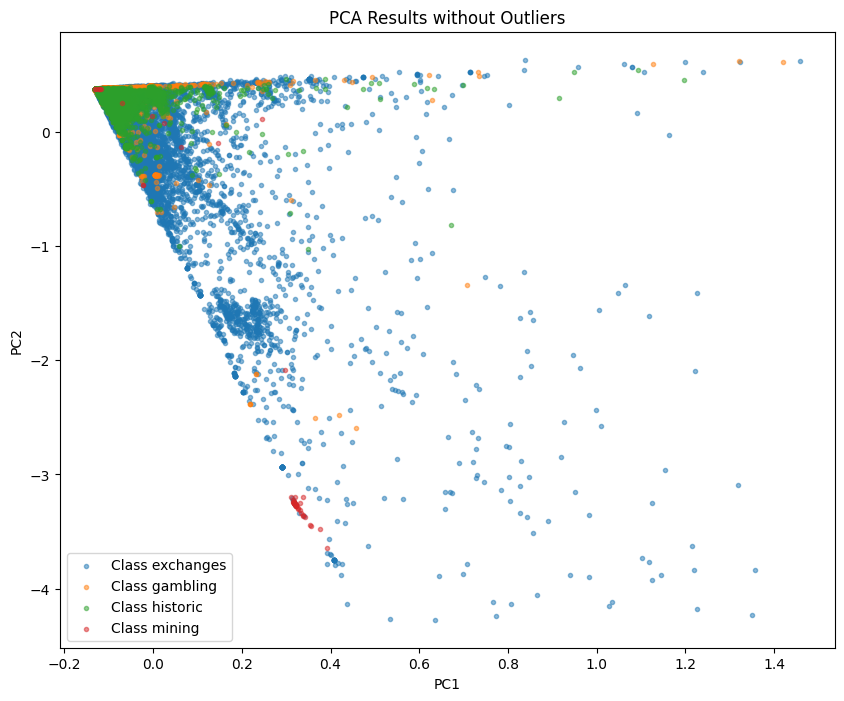

In [ ]:
# Remove outliers based on PC1 and PC2
z_scores_pc1 = np.abs(stats.zscore(PC1_no_service))
z_scores_pc2 = np.abs(stats.zscore(PC2_no_service))

# Set a threshold for outlier detection (usually a z-score of 3 or more is considered an outlier)
threshold = 3

# Find indices where both PC1 and PC2 are not outliers
non_outliers = (z_scores_pc1 < threshold) & (z_scores_pc2 < threshold)

# Filter data to remove outliers
PC1_filtered = PC1_no_service[non_outliers]
PC2_filtered = PC2_no_service[non_outliers]
classes_filtered = classes_filtered_no_service[non_outliers]

# Create a scatter plot without outliers
plt.figure(figsize=(10, 8))
for class_value in np.unique(classes_filtered):
    # Select indices for data points of the current class
    idx = classes_filtered == class_value

    # Plot data points of this class
    plt.scatter(PC1_filtered[idx], PC2_filtered[idx], label=f'Class {class_value}', marker='.', alpha=0.5)

# Adding title and labels
plt.title('PCA Results without Outliers')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add a legend to show class labels
plt.legend()

# Show plot
plt.show()

#### Visualisation of Model predictions on the test dataset

We applied Principla Component Analysis to visaluse the predictions of the KNN model trained on dataset excluding 'no_label' observations. Unofrunately, 2D visualisation with colors applied based on categorical classes predicted does not bring much insight into how classes are mispredicted by the model, and which classes are particularly similar to each other in terms of model predictions. Visualisation shows high cummulation of datapoints of all classes in one area, with classes 'service' and 'exchanges' being more widely spread across the whole graph, probably because of their dominance in the dataset.

### Support Vector Machine classifier on everything 'no_labels'

In [ ]:
features_sample = sample_df.loc[:,selected_features_labels_only].to_numpy()
target_sample = sample_df.iloc[:,-1].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(features_sample, target_sample, test_size = 0.20, random_state=2137, stratify=target_sample)

y_train_encoded = le.fit_transform(y_train)

In [ ]:
from cuml.svm import LinearSVC

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.fit_transform(x_test)

svc=LinearSVC()

svc.fit(x_train_std, y_train_encoded)

y_pred = svc.predict(x_test_std)

In [ ]:
y_test_np = np.array(le.transform(y_test))
y_pred_np = y_pred.get()

accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np, average='macro')
recall = recall_score(y_test_np, y_pred_np, average='macro')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.6777
Precision: 0.27818147350052624
Recall: 0.20800370358897738


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from cuml.svm import SVC
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score, make_scorer

svc=SVC()

# declare parameters for hyperparameter tuning
parameters = [
               {'C':[1, 2, 10], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.5, 1.0]},
             ]

grid_search = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           cv = 3,
                           verbose=2)

grid_result = grid_search.fit(x_train_std, y_train_encoded)

In [ ]:
svc_1 = grid_result.best_estimator_
grid_result.best_score_

0.7700499892234802

In [ ]:
y_pred = svc_1.predict(x_test_std)

y_test_np = np.array(le.transform(y_test))
y_pred_np = y_pred.get()

accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np, average='macro')
recall = recall_score(y_test_np, y_pred_np, average='macro')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.74505
Precision: 0.4580119250348222
Recall: 0.4655684243098383


### Random Forest Classifier on data without "no_label"

In [ ]:
features_sample = sample_df.loc[:,selected_features_labels_only].to_numpy()
target_sample = sample_df.iloc[:,-1].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(features_sample, target_sample, test_size = 0.20, random_state=2137, stratify=target_sample)

y_train_encoded = le.fit_transform(y_train)

In [ ]:
# Random Forrest Classifier did not work with GridSearchCV on GPU (cuML) -> sklearn version was applied
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.fit_transform(x_test)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# Create Random Forest model
rf_model = RandomForestClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, verbose=2)

# Perform grid search
grid_search.fit(x_train_std.get(), y_train_encoded)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  21.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  11.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  15.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=  24.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=  18.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=300; total time=  16.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END max_depth=10, min_samples_split=5, n_es

In [ ]:
rf = grid_search.best_estimator_

y_pred = rf.predict(x_test_std.get())

y_test_np = np.array(le.transform(y_test))
y_pred_np = y_pred

accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np, average='macro')
recall = recall_score(y_test_np, y_pred_np, average='macro')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model Accuracy: 0.72785
Precision: 0.410503789656856
Recall: 0.37619924157062457


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Task 3 - Discussion & Experiments Description

To tackle the problem of labels classification based on previously calculated and selected features, we implemented the following strategy:
1. Perform feature selection and modeling separately for datasets including and excluding observiations with type 'no_label'

Separately for the two senarios:

2. Extract sample of n=100.000 from the whole dataset
3. Perform Train/Test split on the sample (stratified by label, seed=2137)
4. Select classifiers to experiment: KNN, SVM Classifier, Random Forest Classifier
5. Standardize the predictors (training columns)
5. Perform GridSearchCV for multiple parameters on the sample dataset for each
6. Measue performance of best estimator from GridSearchCV on test data (from sample), for future referene
7. Save parameters of best estimator
8. Perform Train/Test split from the whole dataset with selected features
9. Fit the best performing model (on sample n=100000) with its best sample dataset parameters
10. Test the performance of the model on the train set
11. Analyse performance metrics: Accuracy, Precision and Recall
12. Analyse confusion matrix
13. Train model with best parameters on the whole dataset and assess it with cross valiadation (cv=10)

Addiitonally, for the best performing model (KNN) we also tried analysing the test dataset predictions by performing PCA and T-SNE, to see if predictions can be visualised as distinctive groups. However, even despite of trying different visualisations and removal of outliers, the analysis did not bring a lot of insight.


#### Modeling Report:
- accuracy: 0.825
- balanced accuracy: 0.629
- recall: 0.629
- precision: 0.724


The trained model is K-Neares Neighbours with parameters [n_neighbors=10, distance='manhattan', weights='uniform'], trained on dataset excluding observations without a label. To minimize the effect of randomness from Train/Test split, we also implemented model evaluation if it was trained on the whole dataset. Performance metrics were calculated with 10-Fold cross validation. The final KNN model achieved 0.63 of balanced accuracy (0.825 of accuracy), 0.63 of recall and 0.72 of precision. These unbiased scores indicate that the overall performance of the KNN model on all classes is not the best, however, the metrics are less biased by the randomness introduced with train-test split.

Different architercutres SVM and Random Forest Classifier as well as approach to trainign data were implemented. Without success on obtaining better results on sample dataset than KNN. Also, due to computational limitations, GridSearchCV could not check too many variations for SVM, and it was always crashing on fitting SVMs with Polynomial Kernel, hence only Linear and RBF kernels were applied.

Also, interestingly, before applying currently presented experimentation strategy, we tried training the models without Standardizing the data with `sklearn.preprocessing.StandardScaler`. After applying standardization, KNN model achieved rise in Accuracy, Precision and Recall metrics of more than 0.1 per metric, when trained on the whole dataset.

The performance of the current model is not high supposedly due to imbalance of classes, some classes appearing in very small numebrs due to taking only fraction of the available data (computational resources limitation), as well as, inaccuracy of calculated predictors (again, caused by computational limitations). However, experimentation explored draws a clear path to further model development and gives significant insight into building a modeling pipeline, for analysis with higher computational resources available. With enough computational resources to load and transform all available data about Bitcoin transactions, calculated statistics can lead to highly performing models on classifying certain classes of Addresses.

## Exercise 4 [4 points]

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


---
If we do not have labels and want to create groups of addresses this is a unsupervised learning tasks. We are going to use K-means for it. K-means tries to find k clusters where the mean distance of points of one cluster to the center of the cluster is minimized.

In [ ]:
final_df = pd.read_csv('drive/MyDrive/finalDF.csv', index_col=0, compression="gzip") #newly load finalDF (everything from before would crash RAM Limits)

We are going to use the features we identified as good in Excercise 3. While of course this selection was made on the basis of the given Labels, still these features seem to show most variance and are therfore suitable for clustering (as many of the calculated statistics are 0 for the timeframe of the datafiles). Maybe we will also with the same features be able to detect similar clusters as the provided labels.

In [ ]:
selected_features = ['TransVolumeUSD', 'InputUniqueCounterparties', 'OutputUniqueCounterparties', 'AvgDailyFreqInput', 'MaxInputPerDay', 'MaxOutputPerDay', 'AvgDailyFreqOutput']

First we are going to use dimensionality reduction to visualize the data and see if there are visible clusters k-means might identify later.
We are going to use PCA and t-SNE for dimensionality reduction. In order to improve results we will Scale the data.

In [ ]:
from sklearn.preprocessing import StandardScaler

features = final_df.loc[:,selected_features].copy().fillna(0)

scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

features.head(2)

,TransVolumeUSD,InputUniqueCounterparties,OutputUniqueCounterparties,AvgDailyFreqInput,MaxInputPerDay,MaxOutputPerDay,AvgDailyFreqOutput
0,-0.161973,-0.017353,-0.001900,-0.005101,-0.02515,-0.038733,-0.006947
1,-0.159786,-0.017353,0.009222,-0.002305,-0.02515,-0.038733,-0.001181


In [ ]:
#pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(features)

pc1 = df_pca[:,0]
pc2 = df_pca[:,1]

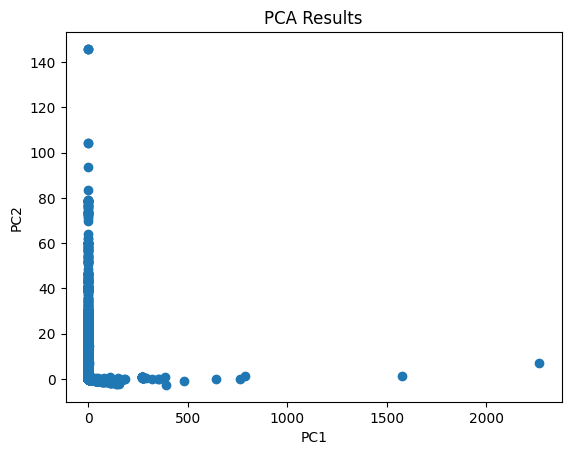

In [ ]:
# plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2)

# Adding title and labels
plt.title('PCA Results')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show plot
plt.show()

In [ ]:
#tsne
from cuml import TSNE
#from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
components = tsne.fit_transform(features)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [16:31:03.674007] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [ ]:
c1 = components.iloc[:,0]
c2 = components.iloc[:,1]

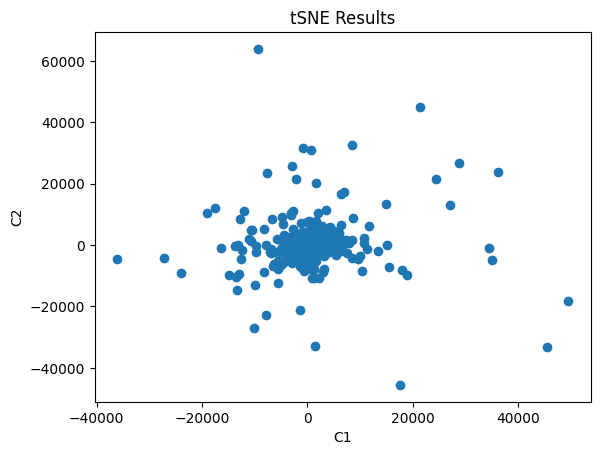

In [ ]:
# plt.figure(figsize=(8, 6))
plt.scatter(c1, c2)

# Adding title and labels
plt.title('tSNE Results')
plt.xlabel('C1')
plt.ylabel('C2')

# Show plot
plt.show()

TSNE seems to produce better results on this data, so we are going to use this going forward and for visualizing the clustered data.


In [ ]:
#with outliers
data_all = pd.concat([c1, c2],axis=1)
data_all.rename({0: "C1", 1: "C2"}, inplace=True, axis=1)
data_all.head(2)

,C1,C2
0,-63.103210,76.482040
1,-17.466829,-107.537415


By evaluation Silhouette Score for different number of Clusters (k) we are going to decide for the best value for parameter k.

<Axes: xlabel='num'>

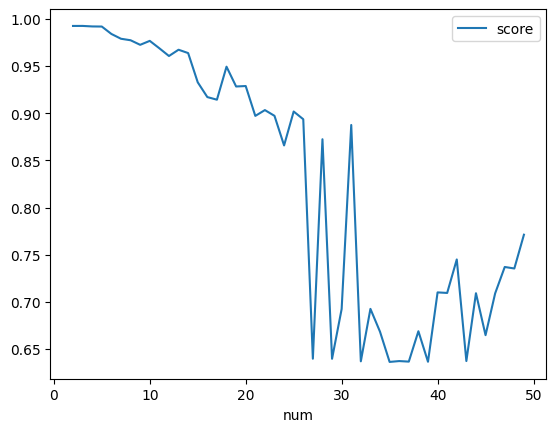

In [ ]:
from cuml import KMeans
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score


def evaluate( dataset, k):
    kmeans = KMeans(handle=None, n_clusters = k, output_type="cudf")
    labels = kmeans.fit_predict(dataset)
    score = cython_silhouette_score(dataset, labels, metric='euclidean')
    #score = kmeans.score(dataset, labels)
    return score


# For each value from 2 to 50 compute the clusters and the score
df = pd.DataFrame(columns=['num','score'])
for i in range(2,50):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(data_all[:200000],i)}).to_frame().T], ignore_index=True) #score is reversed silhouette

# Plot the scores
df.plot( x="num", y="score")

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, n_init='auto', random_state=1)

# Generate a model from the dataset
kmeans.fit(data_all)

# Shows the result.
print("Cluster Centers: ")
print(kmeans.cluster_centers_)
labels_kmeans = kmeans.predict(data_all)

Cluster Centers: 
[[  15.638336  -12.66801 ]
 [-388.94824   102.211006]]


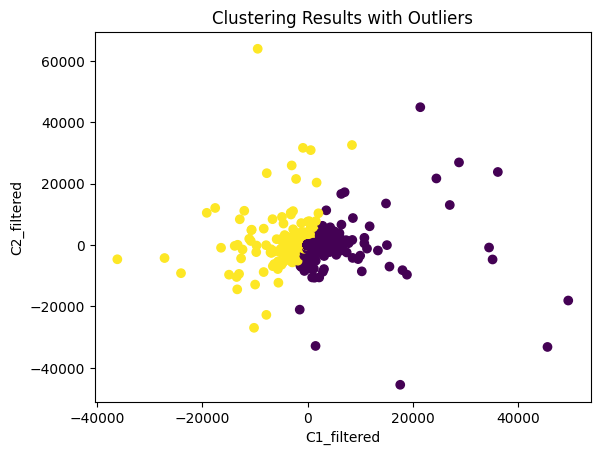

In [ ]:
# plt.figure(figsize=(8, 6))
plt.scatter(c1, c2, c=labels_kmeans)

# Adding title and labels
plt.title('Clustering Results with Outliers')
plt.xlabel('C1_filtered')
plt.ylabel('C2_filtered')

# Show plot
plt.show()

"The K-means clustering algorithm is sensitive to outliers, because a mean is easily influenced by extreme values." [Xin Jin & Jiawei Han; Encyclopedia of Machine Learning](https://link.springer.com/referenceworkentry/10.1007/978-0-387-30164-8_426#:~:text=The%20K%2Dmeans%20clustering%20algorithm,robust%20to%20noises%20and%20outliers.)

This is why we are going to remove outliers and then try to find clusters using K-means.


In [ ]:
#remove outliers
from scipy import stats

# Remove outliers based on PC1 and PC2
z_scores_c1 = np.abs(stats.zscore(c1))
z_scores_c2 = np.abs(stats.zscore(c2))

# Set a threshold for outlier detection (usually a z-score of 3 or more is considered an outlier)
threshold = 4

# Find indices where both PC1 and PC2 are not outliers
non_outliers = (z_scores_c1 < threshold) & (z_scores_c2 < threshold)

# Filter data to remove outliers
C1_filtered = c1[non_outliers]
C2_filtered = c2[non_outliers]

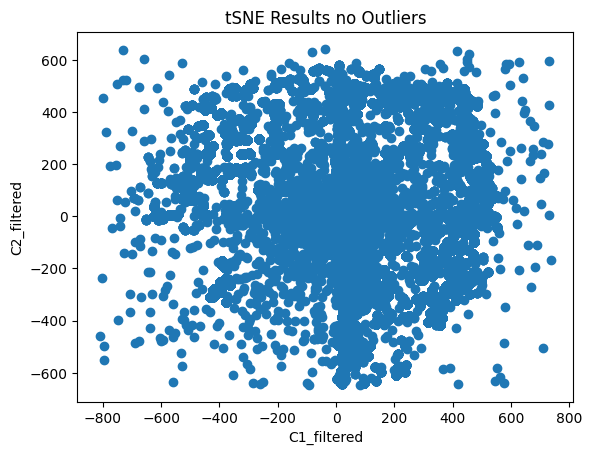

In [ ]:
# plt.figure(figsize=(8, 6))
plt.scatter(C1_filtered, C2_filtered)

# Adding title and labels
plt.title('tSNE Results no Outliers')
plt.xlabel('C1_filtered')
plt.ylabel('C2_filtered')

# Show plot
plt.show()

In [ ]:
data = pd.concat([C1_filtered, C2_filtered],axis=1)
data.rename({0: "C1", 1: "C2"}, inplace=True, axis=1)
data.head(2)

,C1,C2
0,-63.103210,76.482040
1,-17.466829,-107.537415


<Axes: xlabel='num'>

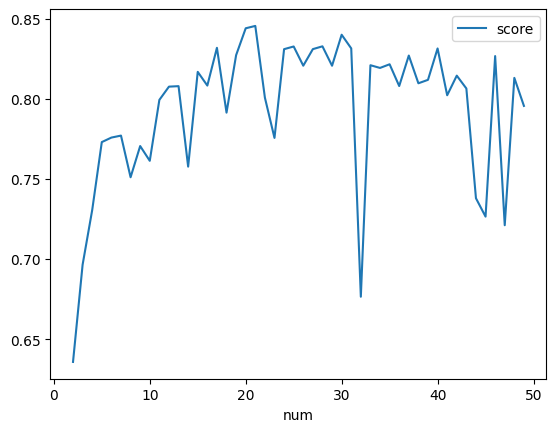

In [ ]:
from cuml import KMeans
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score


def evaluate( dataset, k):
    kmeans = KMeans(handle=None, n_clusters = k, output_type="cudf")
    labels = kmeans.fit_predict(dataset)
    score = cython_silhouette_score(dataset, labels, metric='euclidean')
    #score = kmeans.score(dataset, labels)
    return score


# For each value from 2 to 50 compute the clusters and the score
df = pd.DataFrame(columns=['num','score'])
for i in range(2,50):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(data[:200000],i)}).to_frame().T], ignore_index=True) #score is reversed silhouette

# Plot the scores
df.plot( x="num", y="score")

In [ ]:
df.nlargest(5, "score")

,num,score
19,21.0,0.845589
18,20.0,0.844111
28,30.0,0.840088
26,28.0,0.832849
23,25.0,0.832747


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 21, n_init='auto', random_state=1)

# Generate a model from the dataset
kmeans.fit(data)

# Shows the result.
print("Cluster Centers: ")
print(kmeans.cluster_centers_)
labels_kmeans = kmeans.predict(data)

Cluster Centers: 
[[   5.7910843    -0.79806554]
 [-569.30304       4.9763374 ]
 [ 385.146      -213.25432   ]
 [-197.96872     247.89935   ]
 [  45.127792   -363.96408   ]
 [ 124.81939     468.39542   ]
 [-188.66019     -12.96886   ]
 [ 397.8849      -13.810832  ]
 [-399.49506     195.73245   ]
 [-369.77307       6.8252177 ]
 [  48.152878   -567.28015   ]
 [ 404.5993      415.7012    ]
 [-402.5297     -271.49652   ]
 [ -56.96543     495.1669    ]
 [  46.1902     -121.25002   ]
 [-387.85345     386.60068   ]
 [  39.56803     211.60606   ]
 [ 195.31207    -268.7719    ]
 [-219.2619      349.15237   ]
 [ 471.87308     210.52553   ]
 [ 187.84402       2.0750241 ]]


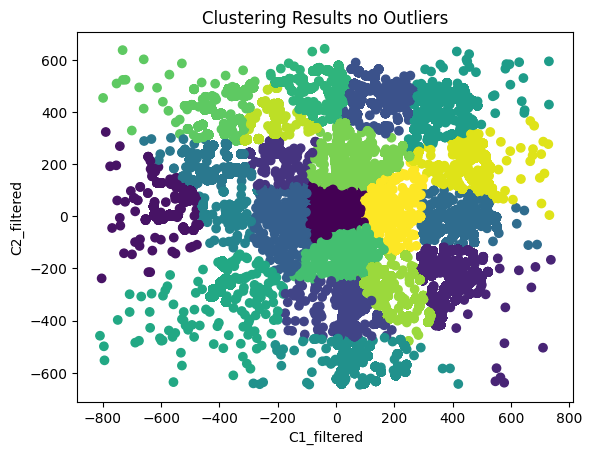

In [ ]:
# plt.figure(figsize=(8, 6))
plt.scatter(C1_filtered, C2_filtered, c=labels_kmeans)

# Adding title and labels
plt.title('Clustering Results no Outliers')
plt.xlabel('C1_filtered')
plt.ylabel('C2_filtered')

# Show plot
plt.show()

#### Discussion

**Explain your code and discuss results**

We performed dimensionality reduction with TSNE and removed outliers and came to the result that k=21 results in the best silhouette score for that filtered data. The result of the clustering can be observed in the cell above.

We also tried before without removing outliers, but decided outliers with a lot of variance from the rest of the data cause a lot of noise with is not good for k-means. The best k value was k=2 there, which is not very interesting for most clustering use cases. The split felt arbitrary. It is interesting to see how the removal of just about 1000 outliers (thats less than 0.5 percent of the data in this case) can have such dramatic effects.

It was great to see how big the difference between sklearn k-means and especially silhouette score (tried with that one before) is compared to GPU accelerated cuml equivalents. This allowed us to use greater sample sizes and therfore probably achieve higher quality results.

## Exercise 5 [3+1 points]

Propose a problem to solve and implement it (for 3 points).

Use cuDF/cuML/cuGrpahs for 1 extra point.

Problem: Identify Addresses that are involved with the darknet Marketplace "SilkRoadMarketplace" [(Wiki)](https://en.wikipedia.org/wiki/Silk_Road_(marketplace)) but might try to hide it by not directly sending BTC to these services but using other addresses as proxies.

We will use label propagation in a graph to set labels of which services addresses interact with most.

---
For this Excercise we are going to use **cuGraph** to first create a graph of the bitcoin transaction data. In the graph addresses are going to be vertices and transactions between addresses will be represented by edges. We decided to create a wheight for every edge, based on the Sum of transaction value over the edge.

With the graph we are first goint to calculate and interpret some network statistics.

In [ ]:
#load required data (only needed if not everything is ran at once; initially loadad in step 0)
inputDF = pd.read_csv("drive/MyDrive/data/inputDF.csv")
outputDF = pd.read_csv("drive/MyDrive/data/outputDF.csv")

consolidatedDF = pd.merge(inputDF, outputDF, on='TxId', how='outer')

In [ ]:
#transform data
wheighted_edges = consolidatedDF[["Input", "Output", "Value"]].groupby(["Input", "Output"]).sum().reset_index()
wheighted_edges.head(2)

,Input,Output,Value
0,111114S8436otvxakSnny9u1KavTTtgeF,15bPd9YSB3kpuAFFz2tBZh39A3XdnN5UoX,0.0081
1,1111219E1WdFoSBE3WVmY3uvHkq2NvnuV,15bPd9YSB3kpuAFFz2tBZh39A3XdnN5UoX,0.0101


In [ ]:
#create graph
import networkx as nx
import cudf
import cugraph

graph = cugraph.from_pandas_edgelist(wheighted_edges, 'Input', 'Output', edge_attr='Value')

In [ ]:
node_count = graph.number_of_nodes()
edge_count = graph.number_of_edges()

print(f"Number of nodes: {node_count}")
print(f"Number of edges: {edge_count}")

Number of nodes: 2625492
Number of edges: 8400280


In [ ]:
# Calculate degree centrality
centrality_scores = cugraph.degree_centrality(graph) #cugraph returns df here
# Get the top 100 nodes based on degree centrality
top_centrality_nodes = centrality_scores.nlargest(10, "degree_centrality")
print("Top 100 nodes based on degree centrality:")
top_centrality_nodes

Top 100 nodes based on degree centrality:


,degree_centrality,vertex
2584625,0.171240,1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
2584636,0.086361,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
2585948,0.051432,1dice7W2AicHosf5EL3GFDUVga7TgtPFn
2584629,0.044972,1dice9wcMu5hLF4g81u8nioL5mmSHTApw
618004,0.039107,17Pe4FLUGL2iEWhDgqzN7xF3mYaNugpHsC
2584624,0.038707,1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx
2585873,0.034547,1dicec9k7KpmQaA8Uc8aCCxfWnwEWzpXE
2585886,0.025051,1dicegEArYHgbwQZhvr5G9Ah2s7SFuW1y
2585944,0.022653,1dice6YgEVBf88erBFra9BHf6ZMoyvG88
2585947,0.019714,1dice7EYzJag7SxkdKXLr8Jn14WUb3Cf1


In [ ]:
# Calculate PageRank
pagerank_scores = cugraph.pagerank(graph, weight='Value')
# Get the top 100 nodes based on PageRank
top_pagerank_nodes = pagerank_scores.nlargest(10, "pagerank")
print("Top 100 nodes based on PageRank:")
top_pagerank_nodes

/usr/local/lib/python3.10/dist-packages/cugraph/link_analysis/pagerank.py:227: UserWarning: Pagerank expects the 'store_transposed' flag to be set to 'True' for optimal performance during the graph creation
  warnings.warn(warning_msg, UserWarning)


Top 100 nodes based on PageRank:


,pagerank,vertex
13139,0.008852,17Pe4FLUGL2iEWhDgqzN7xF3mYaNugpHsC
1423,0.008778,1B5h9sf6xNLYGa3NBk48hwYbxyNZ22PRJk
13136,0.006927,1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
2485,0.006758,1EP4rM8hLZCRSWPNZDWJp9zdvmoWYkkgbQ
9567,0.005228,1Di6ux3CQBNXCZLD76BsnYWDo6XnFGzQah
13149,0.004421,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
13155,0.003736,12WfzWsJBrGEzBYstcUZAfQGPZg5KeqGJh
3921,0.003475,15HJgkvj6roZQvNRC3pUJNKP2YgfEuD8wo
13159,0.003162,1NddXW5aVbhgXPehWqi65jS5mLkBd8wEZc
5220,0.002765,1CaSXzqvbbpsZQk1bYBcXWZG4HfrRFnd4C


It is very interesting to see a lot of adresses starting with "1dice", for example [1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp](https://www.blockchain.com/explorer/addresses/btc/1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp) that made over its whole lifetime allmost **4 million transactions** with a total volume of **79 Billion USD**. After some research we identified them to belong to some bitcoin gambling site "Just-Dice.com" where you could play dice for bitcoin (https://cryptolinks.com/383/just-dicecom). This explains the high degree centrality (number of edges increases by many people gambling on the site) as well as high page rank (people gambling lots of money increasing the wheight of edges and different "important" 1dice adresses interacting with each other).

In [ ]:
print("\nGraph Density:")
actual_connections = edge_count
potential_connections = (node_count * (node_count-1)) / 2

density = actual_connections / potential_connections  #no built in cuGraph method for this
print(density)


Graph Density:
2.437263725255731e-06


This density value is extremely close to zero, indicating a very sparse graph. In the context of Bitcoin transactions, a sparse graph suggests that the majority of addresses (represented by nodes) are not directly transacting with each other. This makes sense taking into account network dynamics and the tendency of entities in a network to not interact with the whole network but rather only a small portion of it (Odlyzko Tilly's law in contrast to Metcalfe's Law).

---
After creating this graph and calulcating and interpreting some of the most important network statistics we are going to use it to propagate the labels we have to solve our Problem of detecting interactions with services. **As attributes are unfortunately not supported in cuGraph, we are forced to use networkx for this part.**

In [ ]:
graph = nx.from_pandas_edgelist(wheighted_edges, 'Input', 'Output', ['Value'])

In [ ]:
# only needed if lables not available
labels = pd.read_csv("drive/MyDrive/sbe2324ada/labels/labels-210000-224000.csv.gz", compression="gzip", header=0,
        usecols=["address", "type", "name"])
labels["address"] = labels["address"].apply(ast.literal_eval)

In order to get good results we need rather balanced labels. Thats why we decided for these 3 types of labels:

In [ ]:
labels = labels[(labels.name == "SilkRoadMarketplace") | (labels.name == "ePay.info") | (labels.name == "Instawallet.org")]

In [ ]:
labels.name.value_counts()

SilkRoadMarketplace    99571
ePay.info              45860
Instawallet.org        30328
Name: name, dtype: int64

SilkRoadMarketplace


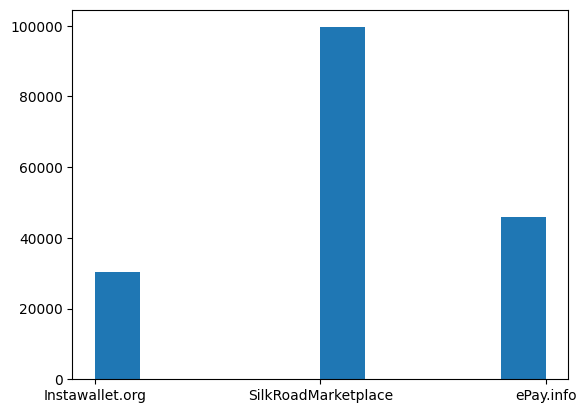

In [ ]:
# add labels as attribute to graph
labels.set_index('address', inplace=True)
nx.set_node_attributes(graph, labels['name'].to_dict(), 'label')

# check if it worked
print(graph.nodes["112FVLNRCqw1UgeSdNeGMy2PgC6KEK24jD"]["label"])

def plot_attribute_dist(G, attribute):
    attribute = nx.get_node_attributes(G, attribute).values()
    plt.hist(attribute)
    plt.show()

plot_attribute_dist(graph, "label")

In [ ]:
import builtins

def label_propagation(graph, max_iterations=5):
    for _ in range(max_iterations):
        for node in graph.nodes():
            neighbor_labels = [graph.nodes[neighbor].get('label') for neighbor in graph.neighbors(node) if 'label' in graph.nodes[neighbor]]
            if neighbor_labels:
                most_common_label = builtins.max(set(neighbor_labels), key=neighbor_labels.count)
                graph.nodes[node]['label'] = most_common_label

label_propagation(graph)

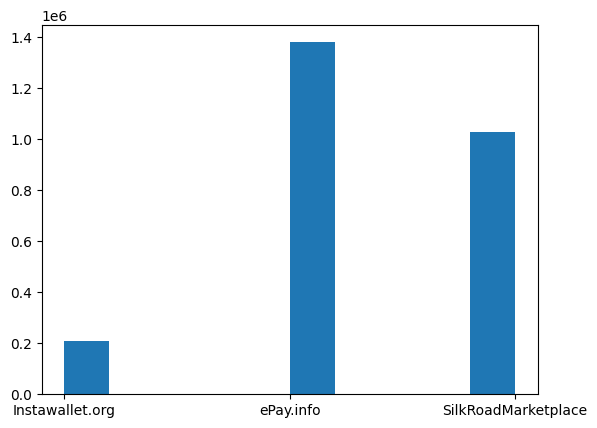

In [ ]:
plot_attribute_dist(graph, "label")

#### Discussion

**Explain your code and discuss results**

By constracting a graph from the data, we are able to analyze it in a unique way. We transformed the transaction data in a way that made it possible to use it as an edgelist for creating the graph.

We then calculated and interpreted some interesting network/graph statistics. Lastly we did label propagation using a subset of labels.

By comparing the 2 histograms showing distribution of labels we can observe, that the label propagation caused a lot of nodes to get the ePay.info Service. Another big amount shifts to SilkRoad Marketplace. **Addresses that are labeled SilkRoadMarketplace should be further analyzed, since they seem to have high interaction or are more closely linked with this darknet marketplace.**